In [1]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)
import sys 
installation_path = "/content/drive/MyDrive/Colab_Installations_V2"
# The path is being modified so that everything installed in the installation path can now be used without re-installing (in this case, I just need biopython)
sys.path.insert(0,installation_path)
protein_mpnn_path = "/content/drive/MyDrive/Protein_MPNN_Digging/ProteinMPNN/vanilla_proteinmpnn"
sys.path.insert(0,protein_mpnn_path)

Mounted at /content/drive


In [2]:
%cd /content/drive/MyDrive/Protein_MPNN_Digging

/content/drive/MyDrive/Protein_MPNN_Digging


In [3]:
import re
import matplotlib.pyplot as plt
import shutil
import warnings
import numpy as np
import torch
from torch import optim
from torch.utils.data import DataLoader
from torch.utils.data.dataset import random_split, Subset
import copy
import torch.nn as nn
import torch.nn.functional as F
import random
import os
from Bio.PDB import *

device = torch.device("cuda" if (torch.cuda.is_available()) else "cpu")

In [4]:
import pandas as pd
from tqdm.notebook import tqdm
from Bio.PDB.Polypeptide import *
from string import ascii_uppercase

In [5]:
weights_path = os.path.join(protein_mpnn_path,"vanilla_model_weights")
model_name = "v_48_020"
checkpoint_path = os.path.join(weights_path,model_name+".pt")

In [6]:
# Now, load and dig into the checkpoint object
checkpoint = torch.load(checkpoint_path, map_location=device) 

In [7]:
print(checkpoint["num_edges"])

48


In [8]:
from __future__ import print_function
import json, time, os, sys, glob
import shutil
import numpy as np
import torch
from torch import optim
from torch.utils.data import DataLoader
from torch.utils.data.dataset import random_split, Subset

import copy
import torch.nn as nn
import torch.nn.functional as F
import random
import itertools

#A number of functions/classes are adopted from: https://github.com/jingraham/neurips19-graph-protein-design

def _scores(S, log_probs, mask):
    """ Negative log probabilities """
    criterion = torch.nn.NLLLoss(reduction='none')
    loss = criterion(
        log_probs.contiguous().view(-1,log_probs.size(-1)),
        S.contiguous().view(-1)
    ).view(S.size())
    # The designable positions have mask set to 1.0, so this function seems to be returning the average score for the designable positions
    scores = torch.sum(loss * mask, dim=-1) / torch.sum(mask, dim=-1)
    return scores

def _S_to_seq(S, mask):
    # This is the decoding order
    alphabet = 'ACDEFGHIKLMNPQRSTVWYX'
    seq = ''.join([alphabet[c] for c, m in zip(S.tolist(), mask.tolist()) if m > 0])
    return seq

def parse_PDB_biounits(x, atoms=['N','CA','C'], chain=None):
  '''
  input:  x = PDB filename
          atoms = atoms to extract (optional)
  output: (length, atoms, coords=(x,y,z)), sequence
  '''

  alpha_1 = list("ARNDCQEGHILKMFPSTWYV-")
  states = len(alpha_1)
  alpha_3 = ['ALA','ARG','ASN','ASP','CYS','GLN','GLU','GLY','HIS','ILE',
             'LEU','LYS','MET','PHE','PRO','SER','THR','TRP','TYR','VAL','GAP']
  
  # The following dictionaries are mapping from one-letter to 0-20 index,
  # three-letter to 0-20 index,
  # 0-20 index to one-letter,
  # one-letter to three-letter, and vice-versa 
  aa_1_N = {a:n for n,a in enumerate(alpha_1)}
  aa_3_N = {a:n for n,a in enumerate(alpha_3)}
  aa_N_1 = {n:a for n,a in enumerate(alpha_1)}
  aa_1_3 = {a:b for a,b in zip(alpha_1,alpha_3)}
  aa_3_1 = {b:a for a,b in zip(alpha_1,alpha_3)}
  
  def AA_to_N(x):
    # ["ARND"] -> [[0,1,2,3]]
    x = np.array(x);
    if x.ndim == 0: x = x[None]
    return [[aa_1_N.get(a, states-1) for a in y] for y in x]
  
  def N_to_AA(x):
    # [[0,1,2,3]] -> ["ARND"]
    x = np.array(x);
    if x.ndim == 1: x = x[None]
    return ["".join([aa_N_1.get(a,"-") for a in y]) for y in x]

  xyz,seq,min_resn,max_resn = {},{},1e6,-1e6
  for line in open(x,"rb"):
    line = line.decode("utf-8","ignore").rstrip()

    if line[:6] == "HETATM" and line[17:17+3] == "MSE":
      line = line.replace("HETATM","ATOM  ")
      line = line.replace("MSE","MET")

    if line[:4] == "ATOM":
      ch = line[21:22]
      # If the input chain is not in the PDB file, which can be the case if the target chains are named differently in the runner script,
      # this line will cause the output to have literally no information, this is the case for integer named chains
      # that does not mean that this line is not doing its job correctly, this is just a constraint that input chain names and 
      # chain names in the PDB file have to be congruent
      if ch == chain or chain is None:
        atom = line[12:12+4].strip()
        resi = line[17:17+3]
        resn = line[22:22+5].strip()
        x,y,z = [float(line[i:(i+8)]) for i in [30,38,46]]

        if resn[-1].isalpha(): 
            resa,resn = resn[-1],int(resn[:-1])-1
        else: 
            resa,resn = "",int(resn)-1
#         resn = int(resn)
        if resn < min_resn: 
            min_resn = resn
        if resn > max_resn: 
            max_resn = resn
        if resn not in xyz: 
            xyz[resn] = {}
        if resa not in xyz[resn]: 
            xyz[resn][resa] = {}
        if resn not in seq: 
            seq[resn] = {}
        if resa not in seq[resn]: 
            seq[resn][resa] = resi

        if atom not in xyz[resn][resa]:
          xyz[resn][resa][atom] = np.array([x,y,z])

  # convert to numpy arrays, fill in missing values
  seq_,xyz_ = [],[]
  try:
      for resn in range(min_resn,max_resn+1):
        if resn in seq:
          for k in sorted(seq[resn]): seq_.append(aa_3_N.get(seq[resn][k],20))
        else: seq_.append(20)
        if resn in xyz:
          for k in sorted(xyz[resn]):
            for atom in atoms:
              if atom in xyz[resn][k]: xyz_.append(xyz[resn][k][atom])
              else: xyz_.append(np.full(3,np.nan))
        else:
          for atom in atoms: xyz_.append(np.full(3,np.nan))
      return np.array(xyz_).reshape(-1,len(atoms),3), N_to_AA(np.array(seq_))
  except TypeError:
      return 'no_chain', 'no_chain'

### calling signature
# pdb_dict_list = parse_PDB(pdb_path, input_chain_list=chain_list)
def parse_PDB(path_to_pdb, input_chain_list=None):
    c=0
    pdb_dict_list = []
    init_alphabet = ['A', 'B', 'C', 'D', 'E', 'F', 'G','H', 'I', 'J','K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T','U', 'V','W','X', 'Y', 'Z', 'a', 'b', 'c', 'd', 'e', 'f', 'g','h', 'i', 'j','k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't','u', 'v','w','x', 'y', 'z']
    extra_alphabet = [str(item) for item in list(np.arange(300))]
    chain_alphabet = init_alphabet + extra_alphabet
     
    if input_chain_list:
        chain_alphabet = input_chain_list  
 

    biounit_names = [path_to_pdb]
    # Each of the biounits is a separate PDB file, so for running with a single PDB file like from colab, this loop will be executed only once
    for biounit in biounit_names:
        my_dict = {}
        s = 0
        concat_seq = ''
        concat_N = []
        concat_CA = []
        concat_C = []
        concat_O = []
        concat_mask = []
        coords_dict = {} 
        # This loop will be executed only once for single chain DDG type cases
        for letter in chain_alphabet:
            xyz, seq = parse_PDB_biounits(biounit, atoms=['N','CA','C','O'], chain=letter)
            if type(xyz) != str:
                concat_seq += seq[0]
                my_dict['seq_chain_'+letter]=seq[0]
                coords_dict_chain = {}
                coords_dict_chain['N_chain_'+letter]=xyz[:,0,:].tolist()
                coords_dict_chain['CA_chain_'+letter]=xyz[:,1,:].tolist()
                coords_dict_chain['C_chain_'+letter]=xyz[:,2,:].tolist()
                coords_dict_chain['O_chain_'+letter]=xyz[:,3,:].tolist()
                my_dict['coords_chain_'+letter]=coords_dict_chain
                s += 1
        fi = biounit.rfind("/")
        my_dict['name']=biounit[(fi+1):-4]
        my_dict['num_of_chains'] = s
        my_dict['seq'] = concat_seq
        if s <= len(chain_alphabet):
            pdb_dict_list.append(my_dict)
            c+=1
    return pdb_dict_list


# X, S, mask, lengths, chain_M, chain_encoding_all, chain_list_list, visible_list_list, masked_list_list, masked_chain_length_list_list, chain_M_pos, omit_AA_mask, residue_idx, dihedral_mask, tied_pos_list_of_lists_list, pssm_coef, pssm_bias, pssm_log_odds_all, bias_by_res_all, tied_beta 
# = tied_featurize(batch_clones, device, chain_id_dict, fixed_positions_dict, omit_AA_dict, tied_positions_dict, pssm_dict, bias_by_res_dict)
# fixed_pos_list = fixed_position_dict[b['name']][letter]
# The trick will be to populate this fixed_position_dict from the calling function, and 
def tied_featurize(batch, device, chain_dict, fixed_position_dict=None, omit_AA_dict=None, tied_positions_dict=None, pssm_dict=None, bias_by_res_dict=None):
    """ Pack and pad batch into torch tensors """
    alphabet = 'ACDEFGHIKLMNPQRSTVWYX'
    B = len(batch)
    lengths = np.array([len(b['seq']) for b in batch], dtype=np.int32) #sum of chain seq lengths
    L_max = max([len(b['seq']) for b in batch])
    X = np.zeros([B, L_max, 4, 3])
    residue_idx = -100*np.ones([B, L_max], dtype=np.int32)
    # This "chain_M" is the variable of interest for controlling which positions will be fixed vs. which will be designed
    # For scoring function-based uses, I intend on sending the sequences one by one for not caring about the slow speed
    # Therefore, B will be == 1
    # So, for now, I just need to somehow manipulate the indexes corresponding to L_max which will be equal to the length of the single sequence as a consequence
    chain_M = np.zeros([B, L_max], dtype=np.int32) #1.0 for the bits that need to be predicted
    pssm_coef_all = np.zeros([B, L_max], dtype=np.float32) #1.0 for the bits that need to be predicted
    pssm_bias_all = np.zeros([B, L_max, 21], dtype=np.float32) #1.0 for the bits that need to be predicted
    pssm_log_odds_all = 10000.0*np.ones([B, L_max, 21], dtype=np.float32) #1.0 for the bits that need to be predicted
    # This "chain_M_pos" is the variable of interest for controlling which positions will be fixed vs. which will be designed
    # For scoring function-based uses, I intend on sending the sequences one by one for not caring about the slow speed
    # Therefore, B will be == 1
    # So, for now, I just need to somehow manipulate the indexes corresponding to L_max which will be equal to the length of single sequence as a consequence
    chain_M_pos = np.zeros([B, L_max], dtype=np.int32) #1.0 for the bits that need to be predicted
    bias_by_res_all = np.zeros([B, L_max, 21], dtype=np.float32)
    # This "chain_encoding_all" is the variable of interest for controlling which positions will be fixed vs. which will be designed
    # For scoring function-based uses, I intend on sending the sequences one by one for not caring about the slow speed
    # Therefore, B will be == 1
    # So, for now, I just need to somehow manipulate the indexes corresponding to L_max which will be equal to the length of single sequence as a consequence
    chain_encoding_all = np.zeros([B, L_max], dtype=np.int32) #1.0 for the bits that need to be predicted
    S = np.zeros([B, L_max], dtype=np.int32)
    omit_AA_mask = np.zeros([B, L_max, len(alphabet)], dtype=np.int32)
    # Build the batch
    letter_list_list = []
    visible_list_list = []
    masked_list_list = []
    masked_chain_length_list_list = []
    tied_pos_list_of_lists_list = []
    #shuffle all chains before the main loop
    for i, b in enumerate(batch):
        # for my current energy function like usecase, the code will reach "if and not else" because chain_dict will not be None
        if chain_dict != None:
            ### Calling function argument assignment START
            # chain_id_dict[pdb_dict_list[0]['name']] = (designed_chain_list, fixed_chain_list)
            ### Calling function argument assignment END
            masked_chains, visible_chains = chain_dict[b['name']] #masked_chains a list of chain letters to predict [A, D, F]
        else:
            masked_chains = [item[-1:] for item in list(b) if item[:10]=='seq_chain_']
            visible_chains = []
        num_chains = b['num_of_chains']
        all_chains = masked_chains + visible_chains
        #random.shuffle(all_chains)
    # This for loop can be ignored since it will be executed only once in my single-chain or single-chain-at-a-time implementation
    for i, b in enumerate(batch):
        mask_dict = {}
        a = 0
        x_chain_list = []
        chain_mask_list = []
        # "chain_seq_list" will contain string format sequences of all the chains both fixed and designable 
        chain_seq_list = []
        chain_encoding_list = []
        c = 1
        # "letter_list" will contain names of all the chains both fixed and designable
        letter_list = []
        global_idx_start_list = [0]
        # "visible_list" will contain names of the fixed chains 
        visible_list = []
        # "masked_list" will contain names of the designable chains
        masked_list = []
        masked_chain_length_list = []
        fixed_position_mask_list = []
        omit_AA_mask_list = []
        pssm_coef_list = []
        pssm_bias_list = []
        pssm_log_odds_list = []
        bias_by_res_list = []
        l0 = 0
        l1 = 0
        # This loop will also be executed once for my single chain case,
        # and since the same chain has both designable and fixed positions, the codes insides both of the if 
        # statements will be executed
        for step, letter in enumerate(all_chains):
            if letter in visible_chains:
                letter_list.append(letter)
                visible_list.append(letter)
                chain_seq = b[f'seq_chain_{letter}']
                chain_seq = ''.join([a if a!='-' else 'X' for a in chain_seq])
                chain_length = len(chain_seq)
                global_idx_start_list.append(global_idx_start_list[-1]+chain_length)
                chain_coords = b[f'coords_chain_{letter}'] #this is a dictionary
                # the "chain_mask" varies between fixed and designable chains (1.0 for designable chains which are maxed)
                chain_mask = np.zeros(chain_length) #0.0 for visible chains
                x_chain = np.stack([chain_coords[c] for c in [f'N_chain_{letter}', f'CA_chain_{letter}', f'C_chain_{letter}', f'O_chain_{letter}']], 1) #[chain_lenght,4,3]
                x_chain_list.append(x_chain)
                chain_mask_list.append(chain_mask)
                chain_seq_list.append(chain_seq)
                # "chain_encoding_list" contains numpy arrays corresponding to chains (each array corresponds to one chain),
                # where all elements of the same array is the same value, which is equal to the index of the chain the it corresponds to
                # by index, I mean index of the different numpy arrays annotating the chains
                chain_encoding_list.append(c*np.ones(np.array(chain_mask).shape[0]))
                # l0 points at the starting of the current chain and l1 points after the ending of the current chain
                l1 += chain_length
                # the only value i will have is 0 since it will be executed only once in my single-chain or single-chain-at-a-time implementation
                # seems like the chains are separated by  
                residue_idx[i, l0:l1] = 100*(c-1)+np.arange(l0, l1)
                l0 += chain_length
                c+=1
                # The following variables are numpy arrays with entries corresponding to every position in the sequence
                # appending these numpy arrays to a list indicates that the chains are added one after one
                # same thing goes for the chain_mask and chain_seq variables declared above
                # In code-block below in this cell, these lists of numpy arrays are going through np.concatenate(), which is creating
                # the final numpy arrays containing co-ordinates, sequence identity, fixed position, masked position, PSSM bias, and everything
                # required to pass the sequences through the model
                ### START
                fixed_position_mask = np.ones(chain_length)
                fixed_position_mask_list.append(fixed_position_mask)
                # The omit_AA_mask, pssm_coef, pssm_bias, "bias_by_res_list", all these numpy arrays are zero for the fixed positions
                # since these positions are used as it is, while for the masked_positions, these values can get activated
                # which is why the next if statement has several extra lines manipulating these variables according to the amount of information passed 
                omit_AA_mask_temp = np.zeros([chain_length, len(alphabet)], np.int32)
                omit_AA_mask_list.append(omit_AA_mask_temp)
                pssm_coef = np.zeros(chain_length)
                pssm_bias = np.zeros([chain_length, 21])
                pssm_log_odds = 10000.0*np.ones([chain_length, 21])
                pssm_coef_list.append(pssm_coef)
                pssm_bias_list.append(pssm_bias)
                pssm_log_odds_list.append(pssm_log_odds)
                bias_by_res_list.append(np.zeros([chain_length, 21]))
                ### END
            if letter in masked_chains:
                masked_list.append(letter)
                letter_list.append(letter)
                chain_seq = b[f'seq_chain_{letter}']
                chain_seq = ''.join([a if a!='-' else 'X' for a in chain_seq])
                chain_length = len(chain_seq)
                global_idx_start_list.append(global_idx_start_list[-1]+chain_length)
                masked_chain_length_list.append(chain_length)
                chain_coords = b[f'coords_chain_{letter}'] #this is a dictionary
                chain_mask = np.ones(chain_length) #1.0 for masked
                x_chain = np.stack([chain_coords[c] for c in [f'N_chain_{letter}', f'CA_chain_{letter}', f'C_chain_{letter}', f'O_chain_{letter}']], 1) #[chain_lenght,4,3]
                x_chain_list.append(x_chain)
                chain_mask_list.append(chain_mask)
                chain_seq_list.append(chain_seq)
                chain_encoding_list.append(c*np.ones(np.array(chain_mask).shape[0]))
                l1 += chain_length
                residue_idx[i, l0:l1] = 100*(c-1)+np.arange(l0, l1)
                l0 += chain_length
                c+=1
                fixed_position_mask = np.ones(chain_length)
                if fixed_position_dict!=None:
                    fixed_pos_list = fixed_position_dict[b['name']][letter]
                    if fixed_pos_list:
                        # seems like "fixed_pos_list"  can be an 1-indexed integer list corresponding to positions in "chain_seq"
                        # this thing ultimately controls which positions in the designable chain will be masked, which is why the fixed 
                        # positions are set to 0.0 since those positions will not be maxed (1 if maxed, 0 if not maxed)
                        fixed_position_mask[np.array(fixed_pos_list)-1] = 0.0
                fixed_position_mask_list.append(fixed_position_mask)
                omit_AA_mask_temp = np.zeros([chain_length, len(alphabet)], np.int32)
                # For my current energy function like usecase, "omit_AA_dict" will be None, so the following loop can be ignored
                if omit_AA_dict!=None:
                    for item in omit_AA_dict[b['name']][letter]:
                        idx_AA = np.array(item[0])-1
                        AA_idx = np.array([np.argwhere(np.array(list(alphabet))== AA)[0][0] for AA in item[1]]).repeat(idx_AA.shape[0])
                        idx_ = np.array([[a, b] for a in idx_AA for b in AA_idx])
                        omit_AA_mask_temp[idx_[:,0], idx_[:,1]] = 1
                omit_AA_mask_list.append(omit_AA_mask_temp)
                pssm_coef = np.zeros(chain_length)
                pssm_bias = np.zeros([chain_length, 21])
                pssm_log_odds = 10000.0*np.ones([chain_length, 21])
                if pssm_dict:
                    if pssm_dict[b['name']][letter]:
                        pssm_coef = pssm_dict[b['name']][letter]['pssm_coef']
                        pssm_bias = pssm_dict[b['name']][letter]['pssm_bias']
                        pssm_log_odds = pssm_dict[b['name']][letter]['pssm_log_odds']
                pssm_coef_list.append(pssm_coef)
                pssm_bias_list.append(pssm_bias)
                pssm_log_odds_list.append(pssm_log_odds)
                if bias_by_res_dict:
                    bias_by_res_list.append(bias_by_res_dict[b['name']][letter])
                else:
                    bias_by_res_list.append(np.zeros([chain_length, 21]))

        ### TIED position START
        # Since there will technically be no tied positions for my single chain energy-based usecase for now,
        # I do not need to dig into this part of the code
        letter_list_np = np.array(letter_list)
        tied_pos_list_of_lists = []
        tied_beta = np.ones(L_max)
        if tied_positions_dict!=None:
            tied_pos_list = tied_positions_dict[b['name']]
            if tied_pos_list:
                set_chains_tied = set(list(itertools.chain(*[list(item) for item in tied_pos_list])))
                for tied_item in tied_pos_list:
                    one_list = []
                    for k, v in tied_item.items():
                        start_idx = global_idx_start_list[np.argwhere(letter_list_np == k)[0][0]]
                        if isinstance(v[0], list):
                            for v_count in range(len(v[0])):
                                one_list.append(start_idx+v[0][v_count]-1)#make 0 to be the first
                                tied_beta[start_idx+v[0][v_count]-1] = v[1][v_count]
                        else:
                            for v_ in v:
                                one_list.append(start_idx+v_-1)#make 0 to be the first
                    tied_pos_list_of_lists.append(one_list)
        tied_pos_list_of_lists_list.append(tied_pos_list_of_lists)
        ### TIED position END
 
        # Interestingly, although the backbone atom coordinates are used for generating edge features,
        # the "x" in the following line contains the coodinates of the backbone atoms 
        x = np.concatenate(x_chain_list,0) #[L, 4, 3]
        # "all_sequence" is a string where all the chain sequences have been put one after another
        all_sequence = "".join(chain_seq_list)
        # This "chain_mask_list" and "m_pos" below are the variables of interest if these actually contain full information regarding the
        # fixed vs. variable positions definitions 
        # consequently, since these are concatenated numpy arrays of numpy arrays inside the lists "chain_mask_list" and "fixed_position_mask_list",
        # when those lists are populated in the above code-block with binary numpy arrays "fixed_position_mask" and "fixed_position_mask" corresponding to 
        # each of the chains,
        # that is where all the controlling needs to be done from
        m = np.concatenate(chain_mask_list,0) #[L,], 1.0 for places that need to be predicted
        # "chain_encoding_list" contains numpy arrays corresponding to chains (each array corresponds to one chain),
        # where all elements of the same array is the same value, which is equal to the index of the chain the it corresponds to
        # by index, I mean index of the different numpy arrays annotating the chains
        chain_encoding = np.concatenate(chain_encoding_list,0)
        m_pos = np.concatenate(fixed_position_mask_list,0) #[L,], 1.0 for places that need to be predicted

        pssm_coef_ = np.concatenate(pssm_coef_list,0) #[L,], 1.0 for places that need to be predicted
        pssm_bias_ = np.concatenate(pssm_bias_list,0) #[L,], 1.0 for places that need to be predicted
        pssm_log_odds_ = np.concatenate(pssm_log_odds_list,0) #[L,], 1.0 for places that need to be predicted

        bias_by_res_ = np.concatenate(bias_by_res_list, 0)  #[L,21], 0.0 for places where AA frequencies don't need to be tweaked

        # Interestingly, all the chains are padded to the same length
        # this has to be done most probably because the same layers are applied to all chains
        # but for single chain or homomer cases, this should not be an issue
        # need to be sure later why this is done
        # does not significant when it comes to single chain energy-based usecase
        # PADDING START
        l = len(all_sequence)
        x_pad = np.pad(x, [[0,L_max-l], [0,0], [0,0]], 'constant', constant_values=(np.nan, ))
        X[i,:,:,:] = x_pad

        m_pad = np.pad(m, [[0,L_max-l]], 'constant', constant_values=(0.0, ))
        m_pos_pad = np.pad(m_pos, [[0,L_max-l]], 'constant', constant_values=(0.0, ))
        omit_AA_mask_pad = np.pad(np.concatenate(omit_AA_mask_list,0), [[0,L_max-l]], 'constant', constant_values=(0.0, ))
        chain_M[i,:] = m_pad
        chain_M_pos[i,:] = m_pos_pad
        omit_AA_mask[i,] = omit_AA_mask_pad

        chain_encoding_pad = np.pad(chain_encoding, [[0,L_max-l]], 'constant', constant_values=(0.0, ))
        chain_encoding_all[i,:] = chain_encoding_pad

        pssm_coef_pad = np.pad(pssm_coef_, [[0,L_max-l]], 'constant', constant_values=(0.0, ))
        pssm_bias_pad = np.pad(pssm_bias_, [[0,L_max-l], [0,0]], 'constant', constant_values=(0.0, ))
        pssm_log_odds_pad = np.pad(pssm_log_odds_, [[0,L_max-l], [0,0]], 'constant', constant_values=(0.0, ))

        pssm_coef_all[i,:] = pssm_coef_pad
        pssm_bias_all[i,:] = pssm_bias_pad
        pssm_log_odds_all[i,:] = pssm_log_odds_pad

        bias_by_res_pad = np.pad(bias_by_res_, [[0,L_max-l], [0,0]], 'constant', constant_values=(0.0, ))
        bias_by_res_all[i,:] = bias_by_res_pad
        # PADDING END

        # Convert to labels
        indices = np.asarray([alphabet.index(a) for a in all_sequence], dtype=np.int32)
        S[i, :l] = indices
        letter_list_list.append(letter_list)
        visible_list_list.append(visible_list)
        masked_list_list.append(masked_list)
        masked_chain_length_list_list.append(masked_chain_length_list)


    isnan = np.isnan(X)
    mask = np.isfinite(np.sum(X,(2,3))).astype(np.float32)
    X[isnan] = 0.

    # Conversion
    pssm_coef_all = torch.from_numpy(pssm_coef_all).to(dtype=torch.float32, device=device)
    pssm_bias_all = torch.from_numpy(pssm_bias_all).to(dtype=torch.float32, device=device)
    pssm_log_odds_all = torch.from_numpy(pssm_log_odds_all).to(dtype=torch.float32, device=device)

    tied_beta = torch.from_numpy(tied_beta).to(dtype=torch.float32, device=device)

    jumps = ((residue_idx[:,1:]-residue_idx[:,:-1])==1).astype(np.float32)
    bias_by_res_all = torch.from_numpy(bias_by_res_all).to(dtype=torch.float32, device=device)
    phi_mask = np.pad(jumps, [[0,0],[1,0]])
    psi_mask = np.pad(jumps, [[0,0],[0,1]])
    omega_mask = np.pad(jumps, [[0,0],[0,1]])
    dihedral_mask = np.concatenate([phi_mask[:,:,None], psi_mask[:,:,None], omega_mask[:,:,None]], -1) #[B,L,3]
    dihedral_mask = torch.from_numpy(dihedral_mask).to(dtype=torch.float32, device=device)
    residue_idx = torch.from_numpy(residue_idx).to(dtype=torch.long,device=device)
    S = torch.from_numpy(S).to(dtype=torch.long,device=device)
    X = torch.from_numpy(X).to(dtype=torch.float32, device=device)
    mask = torch.from_numpy(mask).to(dtype=torch.float32, device=device)
    chain_M = torch.from_numpy(chain_M).to(dtype=torch.float32, device=device)
    chain_M_pos = torch.from_numpy(chain_M_pos).to(dtype=torch.float32, device=device)
    omit_AA_mask = torch.from_numpy(omit_AA_mask).to(dtype=torch.float32, device=device)
    chain_encoding_all = torch.from_numpy(chain_encoding_all).to(dtype=torch.long, device=device)
    # in general, in this return statement, *_list_list has the list inside list format because the outer list corresponds to "batch_clones", 
    # whereas the inner list corresponds to "chains" for each of the elements of "batch_clones"
    # "masked_list_list" contains names of the designable chains (which is my target for single chain energy), whereas "visible_list_list" 
    # contains names of the fixed chains (which should be empty for my single chain energy)
    # for my single chain energy case, "letter_list_list" should be equal to "masked_list_list", and three lists should have one list for now
    # "chain_encoding_all" should also contain chain-index related to the only single chain which should be 0 (all 0s)
    # the last lists starting from "tied_pos_list_of_lists_list" to the end should be irrelevant for my single chain energy case
    # but still it would be good to check the values of these irrelevant lists, and get an idea if everything makes sense or not
    # "chain_M_pos" contains values from "fixed_position_mask" through "m_pos", which should get populated with 0.0 for fixed positions
    # and 1.0 for designable positions, which can be controlled through the , which
    # is controlled by "fixed_position_dict" input to this function from the running script
    # "chain_M" is formed from "m_pad" which comes from "m" which comes from chain_mask = np.ones(chain_length) #1.0 for masked
    # so, for my single chain energy usecase, "chain_M" should be all 1.0s with the same length as chain_M_pos
    # I do not think "X", "S", and "mask" need to be manipulated for now 
    return X, S, mask, lengths, chain_M, chain_encoding_all, letter_list_list, visible_list_list, masked_list_list, masked_chain_length_list_list, chain_M_pos, omit_AA_mask, residue_idx, dihedral_mask, tied_pos_list_of_lists_list, pssm_coef_all, pssm_bias_all, pssm_log_odds_all, bias_by_res_all, tied_beta


# No need to dig into this loss function for now
def loss_nll(S, log_probs, mask):
    """ Negative log probabilities """
    criterion = torch.nn.NLLLoss(reduction='none')
    loss = criterion(
        log_probs.contiguous().view(-1, log_probs.size(-1)), S.contiguous().view(-1)
    ).view(S.size())
    loss_av = torch.sum(loss * mask) / torch.sum(mask)
    return loss, loss_av

# No need to dig into this label smoothing stuff for now
def loss_smoothed(S, log_probs, mask, weight=0.1):
    """ Negative log probabilities """
    S_onehot = torch.nn.functional.one_hot(S, 21).float()

    # Label smoothing
    S_onehot = S_onehot + weight / float(S_onehot.size(-1))
    S_onehot = S_onehot / S_onehot.sum(-1, keepdim=True)

    loss = -(S_onehot * log_probs).sum(-1)
    loss_av = torch.sum(loss * mask) / torch.sum(mask)
    return loss, loss_av

# Objects of this class can be indexed since dunder methods __len()__ and __getitem()__ have been implemented, which 
# indexes a list that has been declared as an instance variable in the constructor,
# and each element of that underlying list is a dictionary containing information regarding a specific sequence
class StructureDataset():
    def __init__(self, jsonl_file, verbose=True, truncate=None, max_length=100,
        alphabet='ACDEFGHIKLMNPQRSTVWYX-'):
        alphabet_set = set([a for a in alphabet])
        discard_count = {
            'bad_chars': 0,
            'too_long': 0,
            'bad_seq_length': 0
        }

        with open(jsonl_file) as f:
            self.data = []

            lines = f.readlines()
            start = time.time()
            for i, line in enumerate(lines):
                entry = json.loads(line)
                seq = entry['seq'] 
                name = entry['name']

                # Convert raw coords to np arrays
                #for key, val in entry['coords'].items():
                #    entry['coords'][key] = np.asarray(val)

                # Check if in alphabet
                bad_chars = set([s for s in seq]).difference(alphabet_set)
                if len(bad_chars) == 0:
                    if len(entry['seq']) <= max_length:
                        if True:
                            self.data.append(entry)
                        else:
                            discard_count['bad_seq_length'] += 1
                    else:
                        discard_count['too_long'] += 1
                else:
                    print(name, bad_chars, entry['seq'])
                    discard_count['bad_chars'] += 1

                # Truncate early
                if truncate is not None and len(self.data) == truncate:
                    return

                if verbose and (i + 1) % 1000 == 0:
                    elapsed = time.time() - start
                    print('{} entries ({} loaded) in {:.1f} s'.format(len(self.data), i+1, elapsed))

            print('discarded', discard_count)
    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]
    

# Objects of this class can be indexed since dunder methods __len()__ and __getitem()__ have been implemented, which 
# indexes a list that has been declared as an instance variable in the constructor,
# and each element of that underlying list is a dictionary containing information regarding a specific structure,
# seems like a structure-specific version of the above method which deals with sequences 
class StructureDatasetPDB():
    def __init__(self, pdb_dict_list, verbose=True, truncate=None, max_length=100,
        alphabet='ACDEFGHIKLMNPQRSTVWYX-'):
        alphabet_set = set([a for a in alphabet])
        discard_count = {
            'bad_chars': 0,
            'too_long': 0,
            'bad_seq_length': 0
        }

        self.data = []

        start = time.time()
        # elements of pdb_dict_list are dictionaries containing information regarding a specific pdb file
        for i, entry in enumerate(pdb_dict_list):
            seq = entry['seq']
            name = entry['name']

            bad_chars = set([s for s in seq]).difference(alphabet_set)
            if len(bad_chars) == 0:
                if len(entry['seq']) <= max_length:
                    self.data.append(entry)
                else:
                    discard_count['too_long'] += 1
            else:
                discard_count['bad_chars'] += 1

            # Truncate early
            if truncate is not None and len(self.data) == truncate:
                return

            if verbose and (i + 1) % 1000 == 0:
                elapsed = time.time() - start

            #print('Discarded', discard_count)
    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]


    
class StructureLoader():
    def __init__(self, dataset, batch_size=100, shuffle=True,
        collate_fn=lambda x:x, drop_last=False):
        self.dataset = dataset
        self.size = len(dataset)
        self.lengths = [len(dataset[i]['seq']) for i in range(self.size)]
        self.batch_size = batch_size
        sorted_ix = np.argsort(self.lengths)

        # Cluster into batches of similar sizes
        clusters, batch = [], []
        batch_max = 0
        for ix in sorted_ix:
            size = self.lengths[ix]
            if size * (len(batch) + 1) <= self.batch_size:
                batch.append(ix)
                batch_max = size
            else:
                clusters.append(batch)
                batch, batch_max = [], 0
        if len(batch) > 0:
            clusters.append(batch)
        self.clusters = clusters

    def __len__(self):
        return len(self.clusters)

    def __iter__(self):
        np.random.shuffle(self.clusters)
        for b_idx in self.clusters:
            batch = [self.dataset[i] for i in b_idx]
            yield batch
            
            
            
# The following gather functions
def gather_edges(edges, neighbor_idx):
    # Features [B,N,N,C] at Neighbor indices [B,N,K] => Neighbor features [B,N,K,C]
    neighbors = neighbor_idx.unsqueeze(-1).expand(-1, -1, -1, edges.size(-1))
    edge_features = torch.gather(edges, 2, neighbors)
    return edge_features

def gather_nodes(nodes, neighbor_idx):
    # Features [B,N,C] at Neighbor indices [B,N,K] => [B,N,K,C]
    # Flatten and expand indices per batch [B,N,K] => [B,NK] => [B,NK,C]
    neighbors_flat = neighbor_idx.view((neighbor_idx.shape[0], -1))
    neighbors_flat = neighbors_flat.unsqueeze(-1).expand(-1, -1, nodes.size(2))
    # Gather and re-pack
    neighbor_features = torch.gather(nodes, 1, neighbors_flat)
    neighbor_features = neighbor_features.view(list(neighbor_idx.shape)[:3] + [-1])
    return neighbor_features

def gather_nodes_t(nodes, neighbor_idx):
    # Features [B,N,C] at Neighbor index [B,K] => Neighbor features[B,K,C]
    idx_flat = neighbor_idx.unsqueeze(-1).expand(-1, -1, nodes.size(2))
    neighbor_features = torch.gather(nodes, 1, idx_flat)
    return neighbor_features

def cat_neighbors_nodes(h_nodes, h_neighbors, E_idx):
    h_nodes = gather_nodes(h_nodes, E_idx)
    h_nn = torch.cat([h_neighbors, h_nodes], -1)
    return h_nn


class EncLayer(nn.Module):
    def __init__(self, num_hidden, num_in, dropout=0.1, num_heads=None, scale=30):
        super(EncLayer, self).__init__()
        self.num_hidden = num_hidden
        self.num_in = num_in
        self.scale = scale
        self.dropout1 = nn.Dropout(dropout)
        self.dropout2 = nn.Dropout(dropout)
        self.dropout3 = nn.Dropout(dropout)
        self.norm1 = nn.LayerNorm(num_hidden)
        self.norm2 = nn.LayerNorm(num_hidden)
        self.norm3 = nn.LayerNorm(num_hidden)

        self.W1 = nn.Linear(num_hidden + num_in, num_hidden, bias=True)
        self.W2 = nn.Linear(num_hidden, num_hidden, bias=True)
        self.W3 = nn.Linear(num_hidden, num_hidden, bias=True)
        self.W11 = nn.Linear(num_hidden + num_in, num_hidden, bias=True)
        self.W12 = nn.Linear(num_hidden, num_hidden, bias=True)
        self.W13 = nn.Linear(num_hidden, num_hidden, bias=True)
        self.act = torch.nn.GELU()
        self.dense = PositionWiseFeedForward(num_hidden, num_hidden * 4)

    def forward(self, h_V, h_E, E_idx, mask_V=None, mask_attend=None):
        """ Parallel computation of full transformer layer """

        h_EV = cat_neighbors_nodes(h_V, h_E, E_idx)
        h_V_expand = h_V.unsqueeze(-2).expand(-1,-1,h_EV.size(-2),-1)
        h_EV = torch.cat([h_V_expand, h_EV], -1)
        h_message = self.W3(self.act(self.W2(self.act(self.W1(h_EV)))))
        if mask_attend is not None:
            h_message = mask_attend.unsqueeze(-1) * h_message
        dh = torch.sum(h_message, -2) / self.scale
        h_V = self.norm1(h_V + self.dropout1(dh))

        dh = self.dense(h_V)
        h_V = self.norm2(h_V + self.dropout2(dh))
        if mask_V is not None:
            mask_V = mask_V.unsqueeze(-1)
            h_V = mask_V * h_V

        h_EV = cat_neighbors_nodes(h_V, h_E, E_idx)
        h_V_expand = h_V.unsqueeze(-2).expand(-1,-1,h_EV.size(-2),-1)
        h_EV = torch.cat([h_V_expand, h_EV], -1)
        h_message = self.W13(self.act(self.W12(self.act(self.W11(h_EV)))))
        h_E = self.norm3(h_E + self.dropout3(h_message))
        return h_V, h_E


class DecLayer(nn.Module):
    def __init__(self, num_hidden, num_in, dropout=0.1, num_heads=None, scale=30):
        super(DecLayer, self).__init__()
        self.num_hidden = num_hidden
        self.num_in = num_in
        self.scale = scale
        self.dropout1 = nn.Dropout(dropout)
        self.dropout2 = nn.Dropout(dropout)
        self.norm1 = nn.LayerNorm(num_hidden)
        self.norm2 = nn.LayerNorm(num_hidden)

        self.W1 = nn.Linear(num_hidden + num_in, num_hidden, bias=True)
        self.W2 = nn.Linear(num_hidden, num_hidden, bias=True)
        self.W3 = nn.Linear(num_hidden, num_hidden, bias=True)
        self.act = torch.nn.GELU()
        self.dense = PositionWiseFeedForward(num_hidden, num_hidden * 4)

    def forward(self, h_V, h_E, mask_V=None, mask_attend=None):
        """ Parallel computation of full transformer layer """

        # Concatenate h_V_i to h_E_ij
        h_V_expand = h_V.unsqueeze(-2).expand(-1,-1,h_E.size(-2),-1)
        h_EV = torch.cat([h_V_expand, h_E], -1)

        # Maybe, length of the message vector can serve as attention
        h_message = self.W3(self.act(self.W2(self.act(self.W1(h_EV)))))
        # the mask attend here is most probably just for zeroing out the padded positions
        # I do not think it will matter that much
        if mask_attend is not None:
            h_message = mask_attend.unsqueeze(-1) * h_message
            # why divide by 30 when we are dealing with 48 neighbors in the current version of the model?
        # Let me check the messages corresponding to 
        dh = torch.sum(h_message, -2) / self.scale

        h_V = self.norm1(h_V + self.dropout1(dh))

        # Position-wise feedforward
        dh = self.dense(h_V)
        h_V = self.norm2(h_V + self.dropout2(dh))

        if mask_V is not None:
            mask_V = mask_V.unsqueeze(-1)
            h_V = mask_V * h_V

        # "h_message" can be returned without dividing by "self.scale" also
        return h_V, (h_message/self.scale) 



class PositionWiseFeedForward(nn.Module):
    def __init__(self, num_hidden, num_ff):
        super(PositionWiseFeedForward, self).__init__()
        self.W_in = nn.Linear(num_hidden, num_ff, bias=True)
        self.W_out = nn.Linear(num_ff, num_hidden, bias=True)
        self.act = torch.nn.GELU()
    def forward(self, h_V):
        h = self.act(self.W_in(h_V))
        h = self.W_out(h)
        return h

class PositionalEncodings(nn.Module):
    def __init__(self, num_embeddings, max_relative_feature=32):
        super(PositionalEncodings, self).__init__()
        self.num_embeddings = num_embeddings
        self.max_relative_feature = max_relative_feature
        self.linear = nn.Linear(2*max_relative_feature+1+1, num_embeddings)

    def forward(self, offset, mask):
        d = torch.clip(offset + self.max_relative_feature, 0, 2*self.max_relative_feature)*mask + (1-mask)*(2*self.max_relative_feature+1)
        d_onehot = torch.nn.functional.one_hot(d, 2*self.max_relative_feature+1+1)
        E = self.linear(d_onehot.float())
        return E

# Does not look like this function needs to be modified for now to use the model as sort of an energy function
# The only thing that could do something is "top_k", which can be changed for considering more or less neighbors
# for each of the nodes, but that too I think does not matter if the default value of top_k is updated by parameter passing
# This function is called from the model itself with node_features=128, edge_features=128, and top_k=48
# ProteinFeatures(node_features, edge_features, top_k=k_neighbors, augment_eps=augment_eps)
class ProteinFeatures(nn.Module):
    def __init__(self, edge_features, node_features, num_positional_embeddings=16,
        num_rbf=16, top_k=30, augment_eps=0., num_chain_embeddings=16):
        """ Extract protein features """
        super(ProteinFeatures, self).__init__()
        self.edge_features = edge_features
        self.node_features = node_features
        self.top_k = top_k
        self.augment_eps = augment_eps 
        self.num_rbf = num_rbf
        self.num_positional_embeddings = num_positional_embeddings

        self.embeddings = PositionalEncodings(num_positional_embeddings)
        node_in, edge_in = 6, num_positional_embeddings + num_rbf*25
        self.edge_embedding = nn.Linear(edge_in, edge_features, bias=False)
        self.norm_edges = nn.LayerNorm(edge_features)

    # the output of this function MUST be analyzed either directly or via some other function to 
    # understand how to get "index/position" of neighbors
    def _dist(self, X, mask, eps=1E-6):
        mask_2D = torch.unsqueeze(mask,1) * torch.unsqueeze(mask,2)
        dX = torch.unsqueeze(X,1) - torch.unsqueeze(X,2)
        D = mask_2D * torch.sqrt(torch.sum(dX**2, 3) + eps)
        D_max, _ = torch.max(D, -1, keepdim=True)
        D_adjust = D + (1. - mask_2D) * D_max
        sampled_top_k = self.top_k
        D_neighbors, E_idx = torch.topk(D_adjust, np.minimum(self.top_k, X.shape[1]), dim=-1, largest=False)
        return D_neighbors, E_idx

    def _rbf(self, D):
        device = D.device
        D_min, D_max, D_count = 2., 22., self.num_rbf
        D_mu = torch.linspace(D_min, D_max, D_count, device=device)
        D_mu = D_mu.view([1,1,1,-1])
        D_sigma = (D_max - D_min) / D_count
        D_expand = torch.unsqueeze(D, -1)
        RBF = torch.exp(-((D_expand - D_mu) / D_sigma)**2)
        return RBF

    def _get_rbf(self, A, B, E_idx):
        D_A_B = torch.sqrt(torch.sum((A[:,:,None,:] - B[:,None,:,:])**2,-1) + 1e-6) #[B, L, L]
        D_A_B_neighbors = gather_edges(D_A_B[:,:,:,None], E_idx)[:,:,:,0] #[B,L,K]
        RBF_A_B = self._rbf(D_A_B_neighbors)
        return RBF_A_B

    # this function will be called with the arguments as forward(), but will return information regarding 
    # the neighbors which I will figure out a way to parse
    def return_neighbor_info(self, X, mask, residue_idx, chain_labels):
        b = X[:,:,1,:] - X[:,:,0,:]
        c = X[:,:,2,:] - X[:,:,1,:]
        a = torch.cross(b, c, dim=-1)
        Cb = -0.58273431*a + 0.56802827*b - 0.54067466*c + X[:,:,1,:]
        Ca = X[:,:,1,:]
        N = X[:,:,0,:]
        C = X[:,:,2,:]
        O = X[:,:,3,:]
 
        D_neighbors, E_idx = self._dist(Ca, mask)


    def forward(self, X, mask, residue_idx, chain_labels):
        if self.augment_eps > 0:
            X = X + self.augment_eps * torch.randn_like(X)
        
        b = X[:,:,1,:] - X[:,:,0,:]
        c = X[:,:,2,:] - X[:,:,1,:]
        a = torch.cross(b, c, dim=-1)
        Cb = -0.58273431*a + 0.56802827*b - 0.54067466*c + X[:,:,1,:]
        Ca = X[:,:,1,:]
        N = X[:,:,0,:]
        C = X[:,:,2,:]
        O = X[:,:,3,:]
 
        D_neighbors, E_idx = self._dist(Ca, mask)

        RBF_all = []
        RBF_all.append(self._rbf(D_neighbors)) #Ca-Ca
        RBF_all.append(self._get_rbf(N, N, E_idx)) #N-N
        RBF_all.append(self._get_rbf(C, C, E_idx)) #C-C
        RBF_all.append(self._get_rbf(O, O, E_idx)) #O-O
        RBF_all.append(self._get_rbf(Cb, Cb, E_idx)) #Cb-Cb
        RBF_all.append(self._get_rbf(Ca, N, E_idx)) #Ca-N
        RBF_all.append(self._get_rbf(Ca, C, E_idx)) #Ca-C
        RBF_all.append(self._get_rbf(Ca, O, E_idx)) #Ca-O
        RBF_all.append(self._get_rbf(Ca, Cb, E_idx)) #Ca-Cb
        RBF_all.append(self._get_rbf(N, C, E_idx)) #N-C
        RBF_all.append(self._get_rbf(N, O, E_idx)) #N-O
        RBF_all.append(self._get_rbf(N, Cb, E_idx)) #N-Cb
        RBF_all.append(self._get_rbf(Cb, C, E_idx)) #Cb-C
        RBF_all.append(self._get_rbf(Cb, O, E_idx)) #Cb-O
        RBF_all.append(self._get_rbf(O, C, E_idx)) #O-C
        RBF_all.append(self._get_rbf(N, Ca, E_idx)) #N-Ca
        RBF_all.append(self._get_rbf(C, Ca, E_idx)) #C-Ca
        RBF_all.append(self._get_rbf(O, Ca, E_idx)) #O-Ca
        RBF_all.append(self._get_rbf(Cb, Ca, E_idx)) #Cb-Ca
        RBF_all.append(self._get_rbf(C, N, E_idx)) #C-N
        RBF_all.append(self._get_rbf(O, N, E_idx)) #O-N
        RBF_all.append(self._get_rbf(Cb, N, E_idx)) #Cb-N
        RBF_all.append(self._get_rbf(C, Cb, E_idx)) #C-Cb
        RBF_all.append(self._get_rbf(O, Cb, E_idx)) #O-Cb
        RBF_all.append(self._get_rbf(C, O, E_idx)) #C-O
        RBF_all = torch.cat(tuple(RBF_all), dim=-1)

        offset = residue_idx[:,:,None]-residue_idx[:,None,:]
        offset = gather_edges(offset[:,:,:,None], E_idx)[:,:,:,0] #[B, L, K]

        d_chains = ((chain_labels[:, :, None] - chain_labels[:,None,:])==0).long() #find self vs non-self interaction
        E_chains = gather_edges(d_chains[:,:,:,None], E_idx)[:,:,:,0]
        E_positional = self.embeddings(offset.long(), E_chains)
        E = torch.cat((E_positional, RBF_all), -1)
        E = self.edge_embedding(E)
        E = self.norm_edges(E)
        return E, E_idx 



class ProteinMPNN(nn.Module):
    # "node_features" and "edge_features" are actually dimensionality of these features ("hidden_dim" in the calling script)
    # the value is 128 for the version that I am using
    def __init__(self, num_letters, node_features, edge_features,
        hidden_dim, num_encoder_layers=3, num_decoder_layers=3,
        vocab=21, k_neighbors=64, augment_eps=0.05, dropout=0.1):
        super(ProteinMPNN, self).__init__()

        # Hyperparameters
        self.node_features = node_features
        self.edge_features = edge_features
        self.hidden_dim = hidden_dim

        # Featurization layers
        # The version that I am using considers 48 neighbors for each position
        self.features = ProteinFeatures(node_features, edge_features, top_k=k_neighbors, augment_eps=augment_eps)

        self.W_e = nn.Linear(edge_features, hidden_dim, bias=True)
        # This W_s is for embedding the sequence
        self.W_s = nn.Embedding(vocab, hidden_dim)

        # Encoder layers
        self.encoder_layers = nn.ModuleList([
            EncLayer(hidden_dim, hidden_dim*2, dropout=dropout)
            for _ in range(num_encoder_layers)
        ])

        # Decoder layers
        self.decoder_layers = nn.ModuleList([
            DecLayer(hidden_dim, hidden_dim*3, dropout=dropout)
            for _ in range(num_decoder_layers)
        ])
        self.W_out = nn.Linear(hidden_dim, num_letters, bias=True)

        for p in self.parameters():
            if p.dim() > 1:
                nn.init.xavier_uniform_(p)

    # Creating my own versions of forward should be an easy way to get embeddings or attention weights from diffrerent layers of the model
    # See here (https://discuss.pytorch.org/t/how-can-i-extract-intermediate-layer-output-from-loaded-cnn-model/77301) in the forums for adding forward
    # hooks or manipulating the forward method
    # but my easy solution would be to create different versions of the forward method with different namaes, and calling them explicitly
    # "chain_M" and "mask" seem to be the things that I need to understand very well and play-around with 
    def forward(self, X, S, mask, chain_M, residue_idx, chain_encoding_all, randn, use_input_decoding_order=False, decoding_order=None):
        """ Graph-conditioned sequence model """
        device=X.device
        # Prepare node and edge embeddings
        E, E_idx = self.features(X, mask, residue_idx, chain_encoding_all)
        h_V = torch.zeros((E.shape[0], E.shape[1], E.shape[-1]), device=E.device)
        h_E = self.W_e(E)

        # Encoder is unmasked self-attention
        mask_attend = gather_nodes(mask.unsqueeze(-1),  E_idx).squeeze(-1)
        mask_attend = mask.unsqueeze(-1) * mask_attend
        for layer in self.encoder_layers:
            h_V, h_E = layer(h_V, h_E, E_idx, mask, mask_attend)

        # Concatenate sequence embeddings for autoregressive decoder
        # h_S denotes embedding of the sequence itself for use in decoder
        h_S = self.W_s(S)
        h_ES = cat_neighbors_nodes(h_S, h_E, E_idx)

        # Build encoder embeddings
        h_EX_encoder = cat_neighbors_nodes(torch.zeros_like(h_S), h_E, E_idx)
        h_EXV_encoder = cat_neighbors_nodes(h_V, h_EX_encoder, E_idx)


        chain_M = chain_M*mask #update chain_M to include missing regions
        if not use_input_decoding_order:
            decoding_order = torch.argsort((chain_M+0.0001)*(torch.abs(randn))) #[numbers will be smaller for places where chain_M = 0.0 and higher for places where chain_M = 1.0]
        mask_size = E_idx.shape[1]
        permutation_matrix_reverse = torch.nn.functional.one_hot(decoding_order, num_classes=mask_size).float()
        order_mask_backward = torch.einsum('ij, biq, bjp->bqp',(1-torch.triu(torch.ones(mask_size,mask_size, device=device))), permutation_matrix_reverse, permutation_matrix_reverse)
        mask_attend = torch.gather(order_mask_backward, 2, E_idx).unsqueeze(-1)
        mask_1D = mask.view([mask.size(0), mask.size(1), 1, 1])
        mask_bw = mask_1D * mask_attend
        mask_fw = mask_1D * (1. - mask_attend)

        h_EXV_encoder_fw = mask_fw * h_EXV_encoder
        for layer in self.decoder_layers:
            # Masked positions attend to encoder information, unmasked see. 
            h_ESV = cat_neighbors_nodes(h_V, h_ES, E_idx)
            h_ESV = mask_bw * h_ESV + h_EXV_encoder_fw
            # only the last layer decoder-messages will be stored in "decoder_messages"
            h_V, decoder_messages = layer(h_V, h_ESV, mask)

        logits = self.W_out(h_V)
        # The probabilities are passed through log() function so that the sequences can be ranked based by summing the respective values 
        # for each position instead of multiplication 
        log_probs = F.log_softmax(logits, dim=-1)
        # messages from the last layer decoder will also be returned for extracting neighbor-attention approximation\
        # last layer embeddings can be extracted from the "h_V" tensor 
        return log_probs, decoder_messages, h_V



    # Seems like this is the method which is used by the notebook for calculating probabilites and scoring
    # Need to dig into it thoroughly
    # "chain_mask" and "residue_idx" seem like the tensors of interest
    def sample(self, X, randn, S_true, chain_mask, chain_encoding_all, residue_idx, mask=None, temperature=1.0, omit_AAs_np=None, bias_AAs_np=None, chain_M_pos=None, omit_AA_mask=None, pssm_coef=None, pssm_bias=None, pssm_multi=None, pssm_log_odds_flag=None, pssm_log_odds_mask=None, pssm_bias_flag=None, bias_by_res=None):
        device = X.device
        # Prepare node and edge embeddings
        E, E_idx = self.features(X, mask, residue_idx, chain_encoding_all)
        h_V = torch.zeros((E.shape[0], E.shape[1], E.shape[-1]), device=device)
        h_E = self.W_e(E)

        # Encoder is unmasked self-attention
        mask_attend = gather_nodes(mask.unsqueeze(-1),  E_idx).squeeze(-1)
        mask_attend = mask.unsqueeze(-1) * mask_attend
        for layer in self.encoder_layers:
            h_V, h_E = layer(h_V, h_E, E_idx, mask, mask_attend)

        # Decoder uses masked self-attention
        chain_mask = chain_mask*chain_M_pos*mask #update chain_M to include missing regions
        decoding_order = torch.argsort((chain_mask+0.0001)*(torch.abs(randn))) #[numbers will be smaller for places where chain_M = 0.0 and higher for places where chain_M = 1.0]
        mask_size = E_idx.shape[1]
        permutation_matrix_reverse = torch.nn.functional.one_hot(decoding_order, num_classes=mask_size).float()
        order_mask_backward = torch.einsum('ij, biq, bjp->bqp',(1-torch.triu(torch.ones(mask_size,mask_size, device=device))), permutation_matrix_reverse, permutation_matrix_reverse)
        mask_attend = torch.gather(order_mask_backward, 2, E_idx).unsqueeze(-1)
        mask_1D = mask.view([mask.size(0), mask.size(1), 1, 1])
        mask_bw = mask_1D * mask_attend
        mask_fw = mask_1D * (1. - mask_attend)

        N_batch, N_nodes = X.size(0), X.size(1)
        log_probs = torch.zeros((N_batch, N_nodes, 21), device=device)
        all_probs = torch.zeros((N_batch, N_nodes, 21), device=device, dtype=torch.float32)
        h_S = torch.zeros_like(h_V, device=device)
        S = torch.zeros((N_batch, N_nodes), dtype=torch.int64, device=device)
        h_V_stack = [h_V] + [torch.zeros_like(h_V, device=device) for _ in range(len(self.decoder_layers))]
        constant = torch.tensor(omit_AAs_np, device=device)
        constant_bias = torch.tensor(bias_AAs_np, device=device)
        #chain_mask_combined = chain_mask*chain_M_pos 
        omit_AA_mask_flag = omit_AA_mask != None


        h_EX_encoder = cat_neighbors_nodes(torch.zeros_like(h_S), h_E, E_idx)
        h_EXV_encoder = cat_neighbors_nodes(h_V, h_EX_encoder, E_idx)
        h_EXV_encoder_fw = mask_fw * h_EXV_encoder
        for t_ in range(N_nodes):
            t = decoding_order[:,t_] #[B]
            chain_mask_gathered = torch.gather(chain_mask, 1, t[:,None]) #[B]
            bias_by_res_gathered = torch.gather(bias_by_res, 1, t[:,None,None].repeat(1,1,21))[:,0,:] #[B, 21]
            if (chain_mask_gathered==0).all():
                S_t = torch.gather(S_true, 1, t[:,None])
            else:
                # Hidden layers
                E_idx_t = torch.gather(E_idx, 1, t[:,None,None].repeat(1,1,E_idx.shape[-1]))
                h_E_t = torch.gather(h_E, 1, t[:,None,None,None].repeat(1,1,h_E.shape[-2], h_E.shape[-1]))
                h_ES_t = cat_neighbors_nodes(h_S, h_E_t, E_idx_t)
                h_EXV_encoder_t = torch.gather(h_EXV_encoder_fw, 1, t[:,None,None,None].repeat(1,1,h_EXV_encoder_fw.shape[-2], h_EXV_encoder_fw.shape[-1]))
                mask_t = torch.gather(mask, 1, t[:,None])
                for l, layer in enumerate(self.decoder_layers):
                    # Updated relational features for future states
                    h_ESV_decoder_t = cat_neighbors_nodes(h_V_stack[l], h_ES_t, E_idx_t)
                    h_V_t = torch.gather(h_V_stack[l], 1, t[:,None,None].repeat(1,1,h_V_stack[l].shape[-1]))
                    h_ESV_t = torch.gather(mask_bw, 1, t[:,None,None,None].repeat(1,1,mask_bw.shape[-2], mask_bw.shape[-1])) * h_ESV_decoder_t + h_EXV_encoder_t
                    h_V_stack[l+1].scatter_(1, t[:,None,None].repeat(1,1,h_V.shape[-1]), layer(h_V_t, h_ESV_t, mask_V=mask_t))
                # Sampling step
                h_V_t = torch.gather(h_V_stack[-1], 1, t[:,None,None].repeat(1,1,h_V_stack[-1].shape[-1]))[:,0]
                logits = self.W_out(h_V_t) / temperature
                probs = F.softmax(logits-constant[None,:]*1e8+constant_bias[None,:]/temperature+bias_by_res_gathered/temperature, dim=-1)
                if pssm_bias_flag:
                    pssm_coef_gathered = torch.gather(pssm_coef, 1, t[:,None])[:,0]
                    pssm_bias_gathered = torch.gather(pssm_bias, 1, t[:,None,None].repeat(1,1,pssm_bias.shape[-1]))[:,0]
                    probs = (1-pssm_multi*pssm_coef_gathered[:,None])*probs + pssm_multi*pssm_coef_gathered[:,None]*pssm_bias_gathered
                if pssm_log_odds_flag:
                    pssm_log_odds_mask_gathered = torch.gather(pssm_log_odds_mask, 1, t[:,None, None].repeat(1,1,pssm_log_odds_mask.shape[-1]))[:,0] #[B, 21]
                    probs_masked = probs*pssm_log_odds_mask_gathered
                    probs_masked += probs * 0.001
                    probs = probs_masked/torch.sum(probs_masked, dim=-1, keepdim=True) #[B, 21]
                if omit_AA_mask_flag:
                    omit_AA_mask_gathered = torch.gather(omit_AA_mask, 1, t[:,None, None].repeat(1,1,omit_AA_mask.shape[-1]))[:,0] #[B, 21]
                    probs_masked = probs*(1.0-omit_AA_mask_gathered)
                    probs = probs_masked/torch.sum(probs_masked, dim=-1, keepdim=True) #[B, 21]
                # Here is where sampling from the multinomial distribution is happening
                # this will sample 1 element according to the given distribution, and return the index of that element [from 0 to 20]
                S_t = torch.multinomial(probs, 1)
                all_probs.scatter_(1, t[:,None,None].repeat(1,1,21), (chain_mask_gathered[:,:,None,]*probs[:,None,:]).float())
            S_true_gathered = torch.gather(S_true, 1, t[:,None])
            S_t = (S_t*chain_mask_gathered+S_true_gathered*(1.0-chain_mask_gathered)).long()
            temp1 = self.W_s(S_t)
            h_S.scatter_(1, t[:,None,None].repeat(1,1,temp1.shape[-1]), temp1)
            S.scatter_(1, t[:,None], S_t)
        output_dict = {"S": S, "probs": all_probs, "decoding_order": decoding_order}
        return output_dict


    def tied_sample(self, X, randn, S_true, chain_mask, chain_encoding_all, residue_idx, mask=None, temperature=1.0, omit_AAs_np=None, bias_AAs_np=None, chain_M_pos=None, omit_AA_mask=None, pssm_coef=None, pssm_bias=None, pssm_multi=None, pssm_log_odds_flag=None, pssm_log_odds_mask=None, pssm_bias_flag=None, tied_pos=None, tied_beta=None, bias_by_res=None):
        device = X.device
        # Prepare node and edge embeddings
        E, E_idx = self.features(X, mask, residue_idx, chain_encoding_all)
        h_V = torch.zeros((E.shape[0], E.shape[1], E.shape[-1]), device=device)
        h_E = self.W_e(E)
        # Encoder is unmasked self-attention
        mask_attend = gather_nodes(mask.unsqueeze(-1),  E_idx).squeeze(-1)
        mask_attend = mask.unsqueeze(-1) * mask_attend
        for layer in self.encoder_layers:
            h_V, h_E = layer(h_V, h_E, E_idx, mask, mask_attend)

        # Decoder uses masked self-attention
        chain_mask = chain_mask*chain_M_pos*mask #update chain_M to include missing regions
        decoding_order = torch.argsort((chain_mask+0.0001)*(torch.abs(randn))) #[numbers will be smaller for places where chain_M = 0.0 and higher for places where chain_M = 1.0]

        new_decoding_order = []
        for t_dec in list(decoding_order[0,].cpu().data.numpy()):
            if t_dec not in list(itertools.chain(*new_decoding_order)):
                list_a = [item for item in tied_pos if t_dec in item]
                if list_a:
                    new_decoding_order.append(list_a[0])
                else:
                    new_decoding_order.append([t_dec])
        decoding_order = torch.tensor(list(itertools.chain(*new_decoding_order)), device=device)[None,].repeat(X.shape[0],1)

        mask_size = E_idx.shape[1]
        permutation_matrix_reverse = torch.nn.functional.one_hot(decoding_order, num_classes=mask_size).float()
        order_mask_backward = torch.einsum('ij, biq, bjp->bqp',(1-torch.triu(torch.ones(mask_size,mask_size, device=device))), permutation_matrix_reverse, permutation_matrix_reverse)
        mask_attend = torch.gather(order_mask_backward, 2, E_idx).unsqueeze(-1)
        mask_1D = mask.view([mask.size(0), mask.size(1), 1, 1])
        mask_bw = mask_1D * mask_attend
        mask_fw = mask_1D * (1. - mask_attend)

        N_batch, N_nodes = X.size(0), X.size(1)
        log_probs = torch.zeros((N_batch, N_nodes, 21), device=device)
        all_probs = torch.zeros((N_batch, N_nodes, 21), device=device, dtype=torch.float32)
        h_S = torch.zeros_like(h_V, device=device)
        S = torch.zeros((N_batch, N_nodes), dtype=torch.int64, device=device)
        h_V_stack = [h_V] + [torch.zeros_like(h_V, device=device) for _ in range(len(self.decoder_layers))]
        constant = torch.tensor(omit_AAs_np, device=device)
        constant_bias = torch.tensor(bias_AAs_np, device=device)
        omit_AA_mask_flag = omit_AA_mask != None

        h_EX_encoder = cat_neighbors_nodes(torch.zeros_like(h_S), h_E, E_idx)
        h_EXV_encoder = cat_neighbors_nodes(h_V, h_EX_encoder, E_idx)
        h_EXV_encoder_fw = mask_fw * h_EXV_encoder
        for t_list in new_decoding_order:
            logits = 0.0
            logit_list = []
            done_flag = False
            for t in t_list:
                if (chain_mask[:,t]==0).all():
                    S_t = S_true[:,t]
                    for t in t_list:
                        h_S[:,t,:] = self.W_s(S_t)
                        S[:,t] = S_t
                    done_flag = True
                    break
                else:
                    E_idx_t = E_idx[:,t:t+1,:]
                    h_E_t = h_E[:,t:t+1,:,:]
                    h_ES_t = cat_neighbors_nodes(h_S, h_E_t, E_idx_t)
                    h_EXV_encoder_t = h_EXV_encoder_fw[:,t:t+1,:,:]
                    mask_t = mask[:,t:t+1]
                    for l, layer in enumerate(self.decoder_layers):
                        h_ESV_decoder_t = cat_neighbors_nodes(h_V_stack[l], h_ES_t, E_idx_t)
                        h_V_t = h_V_stack[l][:,t:t+1,:]
                        h_ESV_t = mask_bw[:,t:t+1,:,:] * h_ESV_decoder_t + h_EXV_encoder_t
                        h_V_stack[l+1][:,t,:] = layer(h_V_t, h_ESV_t, mask_V=mask_t).squeeze(1)
                    h_V_t = h_V_stack[-1][:,t,:]
                    logit_list.append((self.W_out(h_V_t) / temperature)/len(t_list))
                    logits += tied_beta[t]*(self.W_out(h_V_t) / temperature)/len(t_list)
            if done_flag:
                pass
            else:
                bias_by_res_gathered = bias_by_res[:,t,:] #[B, 21]
                probs = F.softmax(logits-constant[None,:]*1e8+constant_bias[None,:]/temperature+bias_by_res_gathered/temperature, dim=-1)
                if pssm_bias_flag:
                    pssm_coef_gathered = pssm_coef[:,t]
                    pssm_bias_gathered = pssm_bias[:,t]
                    probs = (1-pssm_multi*pssm_coef_gathered[:,None])*probs + pssm_multi*pssm_coef_gathered[:,None]*pssm_bias_gathered
                if pssm_log_odds_flag:
                    pssm_log_odds_mask_gathered = pssm_log_odds_mask[:,t]
                    probs_masked = probs*pssm_log_odds_mask_gathered
                    probs_masked += probs * 0.001
                    probs = probs_masked/torch.sum(probs_masked, dim=-1, keepdim=True) #[B, 21]
                if omit_AA_mask_flag:
                    omit_AA_mask_gathered = omit_AA_mask[:,t]
                    probs_masked = probs*(1.0-omit_AA_mask_gathered)
                    probs = probs_masked/torch.sum(probs_masked, dim=-1, keepdim=True) #[B, 21]
                S_t_repeat = torch.multinomial(probs, 1).squeeze(-1)
                for t in t_list:
                    h_S[:,t,:] = self.W_s(S_t_repeat)
                    S[:,t] = S_t_repeat
                    all_probs[:,t,:] = probs.float()
        output_dict = {"S": S, "probs": all_probs, "decoding_order": decoding_order}
        return output_dict


    # I am not seeing an immediate use of this method when the model is called through notebook
    # So, will skip further commenting and digging for now
    # But, seems like an interesting way of interacting with the model in a specific way, so
    # might get back to this later
    def conditional_probs(self, X, S, mask, chain_M, residue_idx, chain_encoding_all, randn, backbone_only=False):
        """ Graph-conditioned sequence model """
        device=X.device
        # Prepare node and edge embeddings
        E, E_idx = self.features(X, mask, residue_idx, chain_encoding_all)
        h_V_enc = torch.zeros((E.shape[0], E.shape[1], E.shape[-1]), device=E.device)
        h_E = self.W_e(E)

        # Encoder is unmasked self-attention
        mask_attend = gather_nodes(mask.unsqueeze(-1),  E_idx).squeeze(-1)
        mask_attend = mask.unsqueeze(-1) * mask_attend
        for layer in self.encoder_layers:
            h_V_enc, h_E = layer(h_V_enc, h_E, E_idx, mask, mask_attend)

        # Concatenate sequence embeddings for autoregressive decoder
        h_S = self.W_s(S)
        h_ES = cat_neighbors_nodes(h_S, h_E, E_idx)

        # Build encoder embeddings
        h_EX_encoder = cat_neighbors_nodes(torch.zeros_like(h_S), h_E, E_idx)
        h_EXV_encoder = cat_neighbors_nodes(h_V_enc, h_EX_encoder, E_idx)


        chain_M = chain_M*mask #update chain_M to include missing regions
  
        chain_M_np = chain_M.cpu().numpy()
        idx_to_loop = np.argwhere(chain_M_np[0,:]==1)[:,0]
        log_conditional_probs = torch.zeros([X.shape[0], chain_M.shape[1], 21], device=device).float()

        for idx in idx_to_loop:
            h_V = torch.clone(h_V_enc)
            order_mask = torch.zeros(chain_M.shape[1], device=device).float()
            if backbone_only:
                order_mask = torch.ones(chain_M.shape[1], device=device).float()
                order_mask[idx] = 0.
            else:
                order_mask = torch.zeros(chain_M.shape[1], device=device).float()
                order_mask[idx] = 1.
            decoding_order = torch.argsort((order_mask[None,]+0.0001)*(torch.abs(randn))) #[numbers will be smaller for places where chain_M = 0.0 and higher for places where chain_M = 1.0]
            mask_size = E_idx.shape[1]
            permutation_matrix_reverse = torch.nn.functional.one_hot(decoding_order, num_classes=mask_size).float()
            order_mask_backward = torch.einsum('ij, biq, bjp->bqp',(1-torch.triu(torch.ones(mask_size,mask_size, device=device))), permutation_matrix_reverse, permutation_matrix_reverse)
            mask_attend = torch.gather(order_mask_backward, 2, E_idx).unsqueeze(-1)
            mask_1D = mask.view([mask.size(0), mask.size(1), 1, 1])
            mask_bw = mask_1D * mask_attend
            mask_fw = mask_1D * (1. - mask_attend)

            h_EXV_encoder_fw = mask_fw * h_EXV_encoder
            for layer in self.decoder_layers:
                # Masked positions attend to encoder information, unmasked see. 
                h_ESV = cat_neighbors_nodes(h_V, h_ES, E_idx)
                h_ESV = mask_bw * h_ESV + h_EXV_encoder_fw
                h_V = layer(h_V, h_ESV, mask)

            logits = self.W_out(h_V)
            log_probs = F.log_softmax(logits, dim=-1)
            log_conditional_probs[:,idx,:] = log_probs[:,idx,:]
        return log_conditional_probs


    # I am not seeing an immediate use of this method when the model is called through notebook
    # So, will skip further commenting and digging for now
    # But, seems like an interesting way of interacting with the model in a specific way, so
    # might get back to this later
    def unconditional_probs(self, X, mask, residue_idx, chain_encoding_all):
        """ Graph-conditioned sequence model """
        device=X.device
        # Prepare node and edge embeddings
        E, E_idx = self.features(X, mask, residue_idx, chain_encoding_all)
        h_V = torch.zeros((E.shape[0], E.shape[1], E.shape[-1]), device=E.device)
        h_E = self.W_e(E)

        # Encoder is unmasked self-attention
        mask_attend = gather_nodes(mask.unsqueeze(-1),  E_idx).squeeze(-1)
        mask_attend = mask.unsqueeze(-1) * mask_attend
        for layer in self.encoder_layers:
            h_V, h_E = layer(h_V, h_E, E_idx, mask, mask_attend)

        # Build encoder embeddings
        h_EX_encoder = cat_neighbors_nodes(torch.zeros_like(h_V), h_E, E_idx)
        h_EXV_encoder = cat_neighbors_nodes(h_V, h_EX_encoder, E_idx)

        order_mask_backward = torch.zeros([X.shape[0], X.shape[1], X.shape[1]], device=device)
        mask_attend = torch.gather(order_mask_backward, 2, E_idx).unsqueeze(-1)
        mask_1D = mask.view([mask.size(0), mask.size(1), 1, 1])
        mask_bw = mask_1D * mask_attend
        mask_fw = mask_1D * (1. - mask_attend)

        h_EXV_encoder_fw = mask_fw * h_EXV_encoder
        for layer in self.decoder_layers:
            h_V = layer(h_V, h_EXV_encoder_fw, mask)

        logits = self.W_out(h_V)
        log_probs = F.log_softmax(logits, dim=-1)
        return log_probs

In [ ]:
hidden_dim = 128
num_layers = 3 
# Seems like, backbone_noise is set to 0 at inference path which seems logical
backbone_noise=0.00
mpnn_model = ProteinMPNN(num_letters=21, node_features=hidden_dim, edge_features=hidden_dim, hidden_dim=hidden_dim, num_encoder_layers=num_layers, num_decoder_layers=num_layers, augment_eps=backbone_noise, k_neighbors=checkpoint['num_edges'])
mpnn_model.to(device)
mpnn_model.load_state_dict(checkpoint['model_state_dict'])
mpnn_model.eval()

In [10]:
print(checkpoint['model_state_dict'].keys())

odict_keys(['features.embeddings.linear.weight', 'features.embeddings.linear.bias', 'features.edge_embedding.weight', 'features.norm_edges.weight', 'features.norm_edges.bias', 'W_e.weight', 'W_e.bias', 'W_s.weight', 'encoder_layers.0.norm1.weight', 'encoder_layers.0.norm1.bias', 'encoder_layers.0.norm2.weight', 'encoder_layers.0.norm2.bias', 'encoder_layers.0.norm3.weight', 'encoder_layers.0.norm3.bias', 'encoder_layers.0.W1.weight', 'encoder_layers.0.W1.bias', 'encoder_layers.0.W2.weight', 'encoder_layers.0.W2.bias', 'encoder_layers.0.W3.weight', 'encoder_layers.0.W3.bias', 'encoder_layers.0.W11.weight', 'encoder_layers.0.W11.bias', 'encoder_layers.0.W12.weight', 'encoder_layers.0.W12.bias', 'encoder_layers.0.W13.weight', 'encoder_layers.0.W13.bias', 'encoder_layers.0.dense.W_in.weight', 'encoder_layers.0.dense.W_in.bias', 'encoder_layers.0.dense.W_out.weight', 'encoder_layers.0.dense.W_out.bias', 'encoder_layers.1.norm1.weight', 'encoder_layers.1.norm1.bias', 'encoder_layers.1.norm2.

In [52]:
# Parse and create dictionaries for all the mutations in PremPS 2648
# This dictionary will be a dictionary of dictionaries, where outer-dict keys will be pdbid+mutchain and inner-dict keys will be (wild+pos+mut) and ddg
# the icodes can be brought to picture later
# this "two_level_dict" is literally used everywhere throughout this code for storing all the numbers that are compared with each other under feature-specific keys
git_url = "https://raw.githubusercontent.com/SajidAhmeduiu/PremPS/main/Datasets/S2648/S2648.txt"
dataset =  pd.read_csv(git_url,delimiter="\t")

pdbIds = list(dataset["PDB Id"])
mutChains = list(dataset["Mutated Chain"])
mutations = list(dataset["Mutation_PDB"])
ddgs = list(dataset["DDGexp"])

two_level_dict = {}

for pdbId, mutChain, mutation, ddg in tqdm(zip(pdbIds,mutChains,mutations,ddgs)):
    pos = [int(s) for s in re.findall('-?\d+',mutation)][0]
    wild = mutation[0]
    mut = mutation[len(mutation)-1]

    pdbId = pdbId.lower()

    inner_dict = {}
    inner_dict["mut"] = f"{wild}{pos}{mut}"
    inner_dict["ddg"] = float(ddg)
    outer_key = f"{pdbId}{mutChain}"
    if outer_key not in two_level_dict:
        two_level_dict[f"{pdbId}{mutChain}"] = [inner_dict]
    else:
        two_level_dict[f"{pdbId}{mutChain}"].append(inner_dict)

0it [00:00, ?it/s]

In [53]:
# create a seqres to position mapping dictionary
# This dictionary will be a dictionary of dictionaries, where outer-dict keys will be pdbid+mutchain and inner-dict key will be (wild+pos) and value of 0-indexed position
# the icodes can be brought to picture later
mapping_dict = {}
pdbDirectory = "/content/drive/MyDrive/ACCRE_PyRun_Setup/S_2648_PDB_Files"
parser = PDBParser(QUIET=True)
# some proteins need to be skipped for now due to ICODE related discrapency
proteins_to_skip = []

for filename in tqdm(os.listdir(pdbDirectory)):
    filepath = os.path.join(pdbDirectory,filename)
    structure = parser.get_structure(id=filename.split(".")[0],file=filepath)
    model = structure[0]
    inner_dict = {}
    outer_key = filename.split(".")[0]
    skip_flag = False
    # single chain-assumption in action again
    for chain in model:
        for i,residue in enumerate(chain):
            inner_key = f"{three_to_one(residue.get_resname())}{residue.get_id()[1]}"
            if inner_key not in inner_dict:
                inner_dict[inner_key] = i
            else:
                # For "2immA:N31" and "1lveA:S27", I have been fucked
                # Need to think whether this will effect other positions or I can just avoid these two-protein related mutations for now?
                # Let me just avoid these two proteins for now
                print("YOU HAVE JUST BEEN FUCKED BY ICODE")
                print(f"{outer_key}:{inner_key}")
                skip_flag = True
    # The ICODE related problematic proteins will not be considered for now
    if not skip_flag:
        mapping_dict[outer_key] = inner_dict
    else:
        proteins_to_skip.append(outer_key)

  0%|          | 0/131 [00:00<?, ?it/s]

YOU HAVE JUST BEEN FUCKED BY ICODE
1lveA:S27
YOU HAVE JUST BEEN FUCKED BY ICODE
1lveA:S27
YOU HAVE JUST BEEN FUCKED BY ICODE
2immA:N31
YOU HAVE JUST BEEN FUCKED BY ICODE
2immA:N31


In [13]:
# changing this "parse_PDB_biounits()" function locally for addressing the fucked up integer named chain problem  
def parse_PDB_biounits(x, atoms=['N', 'CA', 'C'], chain=None):
    '''
    input:  x = PDB filename
            atoms = atoms to extract (optional)
    output: (length, atoms, coords=(x,y,z)), sequence
    '''
    alpha_1 = list("ARNDCQEGHILKMFPSTWYV-")
    states = len(alpha_1)
    alpha_3 = ['ALA', 'ARG', 'ASN', 'ASP', 'CYS', 'GLN', 'GLU', 'GLY', 'HIS', 'ILE',
               'LEU', 'LYS', 'MET', 'PHE', 'PRO', 'SER', 'THR', 'TRP', 'TYR', 'VAL', 'GAP']

    # The following dictionaries are mapping from one-letter to 0-20 index,
    # three-letter to 0-20 index,
    # 0-20 index to one-letter,
    # one-letter to three-letter, and vice-versa
    aa_1_N = {a: n for n, a in enumerate(alpha_1)}
    aa_3_N = {a: n for n, a in enumerate(alpha_3)}
    aa_N_1 = {n: a for n, a in enumerate(alpha_1)}
    aa_1_3 = {a: b for a, b in zip(alpha_1, alpha_3)}
    aa_3_1 = {b: a for a, b in zip(alpha_1, alpha_3)}

    def AA_to_N(x):
        # ["ARND"] -> [[0,1,2,3]]
        x = np.array(x);
        if x.ndim == 0: x = x[None]
        return [[aa_1_N.get(a, states - 1) for a in y] for y in x]

    def N_to_AA(x):
        # [[0,1,2,3]] -> ["ARND"]
        x = np.array(x);
        if x.ndim == 1: x = x[None]
        return ["".join([aa_N_1.get(a, "-") for a in y]) for y in x]

    xyz, seq, min_resn, max_resn = {}, {}, 1e6, -1e6
    for line in open(x, "rb"):
        line = line.decode("utf-8", "ignore").rstrip()

        if line[:6] == "HETATM" and line[17:17 + 3] == "MSE":
            line = line.replace("HETATM", "ATOM  ")
            line = line.replace("MSE", "MET")

        if line[:4] == "ATOM":
            ch = line[21:22]
            # If the input chain is not in the PDB file, which can be the case if the target chains are named differently in the runner script,
            # this line will cause the output to have literally no information, this is the case for integer named chains
            # that does not mean that this line is not doing its job correctly, this is just a constraint that input chain names and
            # chain names in the PDB file have to be congruent
            # If "ch" is an integer, map it to alphabet, because input "chain" has been converted to alphabet
            # In rare cases, some PDB files number chains with 1,2,3 instead of A,B,C
            # This "loc_dict" dictionary contains integer to alphabet mapping for weird as fuck integer chain names
            # This conversion will be done only when  chain name is actually an integer
            if ord(ch) >= 49 and ord(ch) <= 57:
                loc_dict = {(idx+1):ch for idx,ch in enumerate(ascii_uppercase)}
                ch =  str(loc_dict[int(ch)])
            if ch == chain or chain is None:
                atom = line[12:12 + 4].strip()
                resi = line[17:17 + 3]
                resn = line[22:22 + 5].strip()
                x, y, z = [float(line[i:(i + 8)]) for i in [30, 38, 46]]

                if resn[-1].isalpha():
                    resa, resn = resn[-1], int(resn[:-1]) - 1
                else:
                    resa, resn = "", int(resn) - 1
                #         resn = int(resn)
                if resn < min_resn:
                    min_resn = resn
                if resn > max_resn:
                    max_resn = resn
                if resn not in xyz:
                    xyz[resn] = {}
                if resa not in xyz[resn]:
                    xyz[resn][resa] = {}
                if resn not in seq:
                    seq[resn] = {}
                if resa not in seq[resn]:
                    seq[resn][resa] = resi

                if atom not in xyz[resn][resa]:
                    xyz[resn][resa][atom] = np.array([x, y, z])

    # convert to numpy arrays, fill in missing values
    seq_, xyz_ = [], []
    try:
        for resn in range(min_resn, max_resn + 1):
            if resn in seq:
                for k in sorted(seq[resn]): seq_.append(aa_3_N.get(seq[resn][k], 20))
            else:
                seq_.append(20)
            if resn in xyz:
                for k in sorted(xyz[resn]):
                    for atom in atoms:
                        if atom in xyz[resn][k]:
                            xyz_.append(xyz[resn][k][atom])
                        else:
                            xyz_.append(np.full(3, np.nan))
            else:
                for atom in atoms: xyz_.append(np.full(3, np.nan))
        return np.array(xyz_).reshape(-1, len(atoms), 3), N_to_AA(np.array(seq_))
    except TypeError:
        return 'no_chain', 'no_chain'

# Took this part out of "utils.py", and put here so that smalll changes can be made to address pesky issues like
# integer named chain, and shit like those
def parse_PDB(path_to_pdb, input_chain_list=None):
    c=0
    pdb_dict_list = []
    init_alphabet = ['A', 'B', 'C', 'D', 'E', 'F', 'G','H', 'I', 'J','K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T','U', 'V','W','X', 'Y', 'Z', 'a', 'b', 'c', 'd', 'e', 'f', 'g','h', 'i', 'j','k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't','u', 'v','w','x', 'y', 'z']
    extra_alphabet = [str(item) for item in list(np.arange(300))]
    chain_alphabet = init_alphabet + extra_alphabet
     
    if input_chain_list:
        chain_alphabet = input_chain_list  
 

    biounit_names = [path_to_pdb]
    # Each of the biounits is a separate PDB file, so for running with a single PDB file like from colab, this loop will be executed only once
    for biounit in biounit_names:
        my_dict = {}
        s = 0
        concat_seq = ''
        concat_N = []
        concat_CA = []
        concat_C = []
        concat_O = []
        concat_mask = []
        coords_dict = {} 
        # This loop will be executed only once for single chain DDG type cases
        for letter in chain_alphabet:
            xyz, seq = parse_PDB_biounits(biounit, atoms=['N','CA','C','O'], chain=letter)
            if type(xyz) != str:
                concat_seq += seq[0]
                my_dict['seq_chain_'+letter]=seq[0]
                coords_dict_chain = {}
                coords_dict_chain['N_chain_'+letter]=xyz[:,0,:].tolist()
                coords_dict_chain['CA_chain_'+letter]=xyz[:,1,:].tolist()
                coords_dict_chain['C_chain_'+letter]=xyz[:,2,:].tolist()
                coords_dict_chain['O_chain_'+letter]=xyz[:,3,:].tolist()
                my_dict['coords_chain_'+letter]=coords_dict_chain
                s += 1
        fi = biounit.rfind("/")
        my_dict['name']=biounit[(fi+1):-4]
        my_dict['num_of_chains'] = s
        my_dict['seq'] = concat_seq
        if s <= len(chain_alphabet):
            pdb_dict_list.append(my_dict)
            c+=1
    return pdb_dict_list

In [48]:
def distance_func_local(X, mask, eps=1E-6):
    mask_2D = torch.unsqueeze(mask,1) * torch.unsqueeze(mask,2)
    dX = torch.unsqueeze(X,1) - torch.unsqueeze(X,2)
    D = mask_2D * torch.sqrt(torch.sum(dX**2, 3) + eps)
    D_max, _ = torch.max(D, -1, keepdim=True)
    D_adjust = D + (1. - mask_2D) * D_max
    top_k = checkpoint["num_edges"]
    sampled_top_k = top_k
    D_neighbors, E_idx = torch.topk(D_adjust, np.minimum(top_k, X.shape[1]), dim=-1, largest=False)
    return D_neighbors, E_idx

def return_neighbor_info(X, mask):
    b = X[:,:,1,:] - X[:,:,0,:]
    c = X[:,:,2,:] - X[:,:,1,:]
    a = torch.cross(b, c, dim=-1)
    Cb = -0.58273431*a + 0.56802827*b - 0.54067466*c + X[:,:,1,:]
    Ca = X[:,:,1,:]
    N = X[:,:,0,:]
    C = X[:,:,2,:]
    O = X[:,:,3,:]

    D_neighbors, E_idx = distance_func_local(Ca, mask)
    # Got the indices of the neighbors, E_idx should be the 0-based indexing of the topK closest neighbors
    # and D_neighbors should be the distances of those neighbors
    return D_neighbors, E_idx

In [15]:
from scipy.special import softmax
from scipy.special import kl_div

In [ ]:
# read in the PDB files from the directory where the S_2648 PDB Files are stored, and set-them up one by one for featuirization, and passing through the model
pdbDirectory = "/content/drive/MyDrive/ACCRE_PyRun_Setup/S_2648_PDB_Files"
parser = PDBParser(QUIET=True)

pdbId_info = []
pos_info = []
neighbor_pos = []
neighbor_attention = []
neighbor_attention_softmaxed = []
neighbor_distances_tracking = []

import time

np.set_printoptions(suppress=True,precision=2)
loc_proteins = []
for i,filename in tqdm(enumerate(os.listdir(pdbDirectory))):
    #ICODE related problematic proteins will be skipped from analysis for now
    if (filename.split(".")[0] not in proteins_to_skip):
        prot_start = time.time()
        print(f"Prot Processing:{i+1}")
        loc_proteins.append(filename.split(".")[0])
        filepath = os.path.join(pdbDirectory,filename)
        structure = parser.get_structure(id=filename.split(".")[0],file=filepath)
        model = structure[0]
        
        # Since there is only one chain, and that same chain is both fixed designable for different residues, extracting that name, and putting them in pertinent lists
        # taking chainname from filename since one of the files "1rtpA.pdb" has chain name with "1" instead of "A"
        # fuck you motherfucking fucked up PDB file submitter. Have you shoved your head into your ass?
        chain_name = (filename.split(".")[0])[-1]
        fixed_chain_list = []
        # the trick is to put the single chain as designable chain, and then create the "fixed_positions_dict" dictionary  
        designed_chain_list = [chain_name]
        chain_list = list(set(designed_chain_list + fixed_chain_list))

        # Using the programs custome PDB parser for processing the PDB files
        pdb_dict_list = parse_PDB(filepath, input_chain_list=chain_list)
        # tacking max_length parameter value from the original colab notebook since I need to process all residues at the same time
        # all the PDB files can technically be processed together and put inside the dataset_valid list-like object, but right now
        # I am trying to keep everything consistent and simple
        # Each element of dataset_valid is a dictionary 
        dataset_valid = StructureDatasetPDB(pdb_dict_list, truncate=None, max_length=20000)

        # Simplying the sequence generation loop
        protein = dataset_valid[0]

        wildtype_seq = protein[f"seq_chain_{designed_chain_list[0]}"]

        # If there are gaps in the wildtype_seq "seq", remove those positions from both the "seq", "" and ('coords_chain_{designed_chain_list[0]}'), 
        # and ('seq_chain_{designed_chain_list[0]}') of the "protein"
        # print(protein.keys())
        # protein is a dict with keys(['seq_chain_A', 'coords_chain_A', 'name', 'num_of_chains', 'seq'])
        # "seq_chain" and "seq_all" are both strings of the same length where gapped positions need to be identified and removed
        seq_chain = protein[f"seq_chain_{designed_chain_list[0]}"]
        seq_all = protein[f"seq"]
        # "coordinates_chain" is a dict with keys(['N_chain_A', 'CA_chain_A', 'C_chain_A', 'O_chain_A'])
        coordinates_chain = protein[f"coords_chain_{designed_chain_list[0]}"]

        
        # The following four variables are lists of length equal to seq_chain and seq_all length
        # Therefore, the gapped positions can be retrived from seq_chain and removed from everything accordingly
        N_chain = coordinates_chain[f"N_chain_{designed_chain_list[0]}"]
        CA_chain = coordinates_chain[f"CA_chain_{designed_chain_list[0]}"]
        C_chain = coordinates_chain[f"C_chain_{designed_chain_list[0]}"]
        O_chain = coordinates_chain[f"O_chain_{designed_chain_list[0]}"]

        # delete everything related to gapped positions now
        # at first, find out the positions that are gapped
        # these gapped positions are absolutely messed up fucked up artifact of some kind of sophistification 
        # provided by proteinMPNN, FUCK YOU motherfucking oversmart CODERS
        N_chain = [v for i,v in enumerate(N_chain) if seq_chain[i] != "-"]
        CA_chain = [v for i,v in enumerate(CA_chain) if seq_chain[i] != "-"]
        C_chain = [v for i,v in enumerate(C_chain) if seq_chain[i] != "-"]
        O_chain = [v for i,v in enumerate(O_chain) if seq_chain[i] != "-"]
        seq_all = [v for i,v in enumerate(seq_all) if seq_chain[i] != "-"]
        seq_chain = [v for i,v in enumerate(seq_chain) if seq_chain[i] != "-"]

        # Now, finally, pack everything back to the dictionary "protein"
        protein[f"seq_chain_{designed_chain_list[0]}"] = seq_chain
        protein[f"seq"] = seq_all
        coordinates_chain[f"N_chain_{designed_chain_list[0]}"] = N_chain
        coordinates_chain[f"CA_chain_{designed_chain_list[0]}"] = CA_chain
        coordinates_chain[f"C_chain_{designed_chain_list[0]}"] = C_chain
        coordinates_chain[f"O_chain_{designed_chain_list[0]}"] = O_chain
        protein[f"coords_chain_{designed_chain_list[0]}"] = coordinates_chain

        # At this point, probably need to put None values in a lot of parameters that are not relevant to my usecase, but need to be sent to featurizer before running model forward
        # For now, I will not tie positions together
        tied_positions_dict = None
        pssm_dict = None
        omit_AA_dict = None
        bias_AA_dict = None
        tied_positions_dict = None
        bias_by_res_dict = None
        alphabet = 'ACDEFGHIKLMNPQRSTVWYX'
        bias_AAs_np = np.zeros(len(alphabet))

        chain_id_dict = {}
        chain_id_dict[pdb_dict_list[0]['name']]= (designed_chain_list, fixed_chain_list)

        BATCH_COPIES = 1

        batch_clones = [copy.deepcopy(protein) for i in range(BATCH_COPIES)]

        # "muts_for_prot" is a list with information about all the mutations in "protein", whose sequence only version is "wildtype_seq" 
        muts_for_prot = two_level_dict[filename.split(".")[0]]
        # "cur_map_dict" will give the 0-based sequence index for the mutations, which will be almost directly used for masking and then running the model
        # 1-based indexing needed for the fixed position
        cur_map_dict = mapping_dict[filename.split(".")[0]]

        for mut_track,mut in enumerate(muts_for_prot):
            print(f"Processing_Mut:{mut_track+1}, From_Prot:{i+1}")
            wild_aa = mut["mut"][0]
            alternate_aa = mut["mut"][-1]
            # (+1) because we need to pass 1-based indexing to tied_featurize() method
            seq_pos = cur_map_dict[mut["mut"][0:-1]] + 1
            # only need to mask the mutated position position in "wildtype_seq" for now
            fixed_positions_dict = {}
            fixed_positions_dict[protein["name"]] = {}
            f_list = []
            for ind_fixed in range(0,len(seq_chain)):
                if (ind_fixed + 1) not in [seq_pos]:
                    f_list.append(ind_fixed + 1)
            fixed_positions_dict[protein["name"]][filename.split(".")[0][-1]] = f_list

            # finally, had to take chain-name from filename instead of biopython parsing to get rid of chain-name with "1" instead of "A" in "1rtpA.pdb"
            X, S, mask, lengths, chain_M, chain_encoding_all, chain_list_list, visible_list_list, masked_list_list, masked_chain_length_list_list, chain_M_pos, \
            omit_AA_mask, residue_idx, dihedral_mask, tied_pos_list_of_lists_list, pssm_coef, pssm_bias, pssm_log_odds_all, bias_by_res_all, tied_beta  \
            = tied_featurize(batch_clones, device, chain_id_dict, fixed_positions_dict, omit_AA_dict, tied_positions_dict, pssm_dict, bias_by_res_dict)
            randn_1 = torch.randn(chain_M.shape, device=X.device)
            log_probs, decoder_messages, node_embedding_info = mpnn_model(X, S, mask, chain_M*chain_M_pos, residue_idx, chain_encoding_all, randn_1)
            # Adding the log_probs to the same inner dictionary where DDG values exist for easier comparison
            mut["log_prob"] = log_probs.cpu().data.numpy()
            
            # the top_k attention weights will be stored here for weighted sum later
            # "seq_pos" is 1-based since "fixed_positions_dict" above needs to hold 1-based indices for the mutation,
            # but accessing the tensors will require 0-based indexing
            seq_index = seq_pos - 1
            # "dim = 1", because decoder_messages[0,seq_index,:,:] should be (48,128), and we want to take norm of each of the 48 vectors across the last dimension,
            # get 48 norm values, and fetch out the k highest values from there
            message_norms = (torch.linalg.vector_norm(x=decoder_messages[0,seq_index,:,:],ord=2,dim=1))
            local_distances, local_neighbors = return_neighbor_info(X, mask)
            # "top_k_attended_neighbor_indices" is the indices from [0,47] corresponding to the highest attended neighbors
            # top_(k-1) can technically be extracted from top_k, but currently just for simplicity and easier debugging, extracting everything separately
            top_15_attention_vals, top_15_attended_neighbor_indices = torch.topk(message_norms,k=15)
            top_10_attention_vals, top_10_attended_neighbor_indices = torch.topk(message_norms,k=10)
            top_5_attention_vals, top_5_attended_neighbor_indices = torch.topk(message_norms,k=5)
            # now, using "local_neighbors" to get the original indices of the neighbors corresponding to the top_k attended positions
            # taking both top_5 and top_10 for now
            top_15_attended_neighbor_indices = local_neighbors[0,seq_index,top_15_attended_neighbor_indices]
            top_10_attended_neighbor_indices = local_neighbors[0,seq_index,top_10_attended_neighbor_indices]
            top_5_attended_neighbor_indices = local_neighbors[0,seq_index,top_5_attended_neighbor_indices]
            top_15_closest_neighbor_indices = local_neighbors[0,seq_index,1:16]
            top_10_closest_neighbor_indices = local_neighbors[0,seq_index,1:11]
            mut["top_15_attention_weights"] = top_15_attention_vals.cpu().data.numpy()
            mut["top_10_attention_weights"] = top_10_attention_vals.cpu().data.numpy()
            mut["top_5_attention_weights"] = top_5_attention_vals.cpu().data.numpy()
            # the neighbor indices corresponding to the top_k attention weights will be stored here for entropy calculation later
            # 0-based indices of the neighbors will be saved so that corresponding log-probability vectors can be extracted readily from "log_prob" keyed value
            mut["top_15_neighbor_indices"] = top_15_attended_neighbor_indices.cpu().data.numpy()
            mut["top_10_neighbor_indices"] = top_10_attended_neighbor_indices.cpu().data.numpy()
            mut["top_5_neighbor_indices"] = top_5_attended_neighbor_indices.cpu().data.numpy()
            mut["top_15_closest_neighbor_indices"] = top_15_closest_neighbor_indices.cpu().data.numpy()
            mut["top_10_closest_neighbor_indices"] = top_10_closest_neighbor_indices.cpu().data.numpy()

            # The lines below are mostly for printing purposes to do external analysis with PyMol,and ROSETTA with Cristina
            loc_pos_scores = []
            for enum_val,(neighbor_p, neighbor_s, neighbor_distance) in enumerate(zip(local_neighbors[0,seq_index,1:15].cpu().data.numpy(),
                                                                 (torch.linalg.vector_norm(x=decoder_messages[0,seq_index,1:15,:],ord=2,dim=1)).cpu().data.numpy(),
                  
                                                               local_distances[0,seq_index,1:15].cpu().data.numpy())):
                # skippoing the first neighbor since it is the mutated position itself
                if enum_val == 0:
                    continue
                pdbId_info.append(filename)
                pos_info.append(seq_index+1)
                neighbor_pos.append(neighbor_p+1)
                neighbor_attention.append(neighbor_s)
                loc_pos_scores.append(neighbor_s)
                neighbor_distances_tracking.append(neighbor_distance)
            # since softmax has to be done over all the neighbors, taking the softmax, and later adding it to the data generation list after
            # neighbor enumeration loop
            loc_pos_scores = softmax(np.array(loc_pos_scores))
            for s in loc_pos_scores:
                neighbor_attention_softmaxed.append(s)

            # take ("neighbor_attention"-weighted sum/average) of the entropies of the top 5 attended neighbors
            # are the neighbors with highest message passing values always among the closest 10?
            # point to be noted that the closest, therefore the first neighbor of every position is the neighbor itself
            # check correlation between distance and attention values since a possible manual edge feature would be distance
            # let us see if the model attends to distant neighbors more, or attention value is inversely proportional to distance?
            # take L2-norms of the message vectors instead of attention
            # take the softmax of L2-norms to approximate attention, although technically the positions are not constrained by each other, this can be considered a sigmoid attention
            # where having neighbors with large messages will effect differently than having neighbors with small messages
            # can this be correlated with position-entropy?
            # the L2-norms should be able to approximate how much each of the neighbors are effecting the mutated position
            # This information can be stored for checking the effect of center mutation on those positions afterwards
            # Identify major interacting partners (neighbors that are important for center prediction, and also which take center into consideration for its own prediction)
            # then check how much the major neighbor position deviates from wildtype due to the mutation
            # another much more simples thing can be to check the deviation for top 10 neighbors
            # this deviation can be calculated using the log(W) for the neighbor before center mutation, and log(W) for the neighbor after center mutation 

            # Now, take top_k most attended positions, make them designable, mutate center, and take change in -log(p) of the wildtype at each of the neighbor positions
            # take weighted sum of these neighbor energy changes, see if there is any correlation
            # next, go for "strong" neighbor positions (both way strong attention)
            # Many of the tensors will take on new values after running the model again with different fixed positions
            
            # the "fixed_positions_dict" has to be repopulated now since neighbor positions will be masked one by one
            # here, "n_ind" is the 0-based index corresponding to one of the "top_k" attended neighbors 
            # these lists will contain the log_probabilities for the top_k most attended neighbors serially
            # before and after making the center mutation currently at hand, these probabilities will be used later for calculating
            # attention_weighted change in neighbor_wildtype probability, attention_weighted_change in KL, and all those things 
            neighbor_w_log_probs = []
            neighbor_m_log_probs = []
            # the following array will contain the identities of the neighbors serially so that specific wildtype neighbor positions in the probability
            # distribution can be extracted later
            neighbor_aa_identities = []
            # "top5" and "top10" should be extractable from "top15", since the neighbor
            neighbor_w_message_vector_coming_from_center = []
            neighbor_m_message_vector_coming_from_center = []
            # I will pick out the neighbor embeddings, and put them inside the lists below
            # But, do I need to access them one by one, or can I just take a slice out of the embedding tensor across the seq_pos dimension?
            # what more information will I get if I fetch out the embeddings one by one?
            # if I want to do a slicing, I might have to make all the neighbors designable at the same time, which will 
            # for one, I can take out the embeddings for each of the neighbors while they are designable, before and 
            # okay, lets say we will fetch the neighbors out, one by one; we can do that right inside the next loop
            # what will be the significance of those neighbor embeddings, in that case?
            # they will see everything around them, expcept the mutated position, will they change much due to that?
            # neighbor embedding difference in that case might actually catch something about the new interactions that have
            # been formed, interesting...very, very interesting
            neighbor_w_embedding_info = []
            neighbor_m_embedding_info = [] 
            # informations are stored serially in the lists
            for n_ind in mut["top_15_neighbor_indices"]:
                neighbor_aa_identities.append(seq_chain[n_ind])
                # Some sequence-input manipulation is done later in this loop, so the wildtype aa is placed in the position, so that
                # previous iteration manipulations do not cause trouble in this iteration
                alpha_tok = "ACDEFGHIKLMNPQRSTVWYX"
                aa_1_N = {a:n for n,a in enumerate(alpha_tok)}
                aa_N_1 = {n:a for n,a in enumerate(alpha_tok)}

                # adding (+1) to n_ind, since fixed positions are 1-indexed in the original implementation
                n_pos = n_ind + 1  
                fixed_positions_dict = {}
                fixed_positions_dict[protein["name"]] = {}
                f_list = []
                for ind_fixed in range(0,len(seq_chain)):
                    # Fixing everything except the "n_pos" neighbor position
                    if (ind_fixed + 1) not in [n_pos]:
                        f_list.append(ind_fixed + 1)
                fixed_positions_dict[protein["name"]][filename.split(".")[0][-1]] = f_list

                # Extracting "n_ind" 21-way log probabilities when the center is wildtype 
                X, S, mask, lengths, chain_M, chain_encoding_all, chain_list_list, visible_list_list, masked_list_list, masked_chain_length_list_list, chain_M_pos, \
                omit_AA_mask, residue_idx, dihedral_mask, tied_pos_list_of_lists_list, pssm_coef, pssm_bias, pssm_log_odds_all, bias_by_res_all, tied_beta  \
                = tied_featurize(batch_clones, device, chain_id_dict, fixed_positions_dict, omit_AA_dict, tied_positions_dict, pssm_dict, bias_by_res_dict)
                randn_1 = torch.randn(chain_M.shape, device=X.device)

                # we want to store the 128-length message vector coming from the center to the neighbor at "n_ind"
                # for this, at first, we need to find which neighbor of "n_ind" is our center so that we can pull out the message vector coming from 
                # the center to the neighbor at "n_ind" 
                loc_local_distances, loc_local_neighbors = return_neighbor_info(X, mask)
                # "neighbor_neighbor_index" is the index of the center with respect to the neighbor at "n_ind"
                # if len(neighbor_neighbor_index) is 0, center is not among the spatially close 48 neighbors of the neighbor at "n_ind"
                # in that case, message vector passed from center to that neighbor can be considered as a 128 length all 0 vector for now
                # for now, it is important to note that if len(neighbor_neighbor_index) is not zero, then the index can be retrived by neighbor_neighbor_index[0][0]  
                neighbor_neighbor_index = (loc_local_neighbors[0,n_ind,:] == seq_index).nonzero(as_tuple=False)
                neighbor_neighbor_index =  neighbor_neighbor_index[0][0] if (len(neighbor_neighbor_index) == 1) else torch.tensor(-1,device=neighbor_neighbor_index.device)

                # calling "mpnn_model" "forward" function three times below for getting the three tensors is definitely not efficient,
                # but, doing it this way for now, since I am getting CUDA out-of-memory errors due to some unsolved (for now) reason   
                n_log_probs  = \
                    mpnn_model(X, S, mask, chain_M*chain_M_pos, residue_idx, chain_encoding_all, randn_1)[0][0,n_ind,:].cpu().data.numpy()
                decoder_message = \
                    mpnn_model(X, S, mask, chain_M*chain_M_pos, residue_idx, chain_encoding_all, randn_1)[1][0,n_ind,neighbor_neighbor_index,:].cpu().data.numpy()
                node_embedding_info = \
                    mpnn_model(X, S, mask, chain_M*chain_M_pos, residue_idx, chain_encoding_all, randn_1)[2][0,n_ind,:].cpu().data.numpy()

                neighbor_w_log_probs.append(n_log_probs)
                neighbor_w_embedding_info.append(node_embedding_info)

                if neighbor_neighbor_index >= 0:
                    neighbor_w_message_vector_coming_from_center.append(decoder_message)
                else:
                    # Adding all-0 vector of length 128 if the center is not among the closest 48 neighbors of center
                    neighbor_w_message_vector_coming_from_center.append(np.zeros(128)) 
                 
                # Now, make mutation, and process the corresponding probabilities
                X, S, mask, lengths, chain_M, chain_encoding_all, chain_list_list, visible_list_list, masked_list_list, masked_chain_length_list_list, chain_M_pos, \
                omit_AA_mask, residue_idx, dihedral_mask, tied_pos_list_of_lists_list, pssm_coef, pssm_bias, pssm_log_odds_all, bias_by_res_all, tied_beta  \
                = tied_featurize(batch_clones, device, chain_id_dict, fixed_positions_dict, omit_AA_dict, tied_positions_dict, pssm_dict, bias_by_res_dict)
                randn_1 = torch.randn(chain_M.shape, device=X.device)
                # seems like passing mutant sequence through the model will be a bit more difficult that expected since PDB file is read in by the underlying parser
                # How, do I only change the amino acids identity in the sequence, but keep the PDB backbone and everything same?
                # At first, just try to manipulate the input "S"
                S[0,seq_index] = aa_1_N[alternate_aa]
                n_log_probs  = \
                    mpnn_model(X, S, mask, chain_M*chain_M_pos, residue_idx, chain_encoding_all, randn_1)[0][0,n_ind,:].cpu().data.numpy()
                decoder_message = \
                    mpnn_model(X, S, mask, chain_M*chain_M_pos, residue_idx, chain_encoding_all, randn_1)[1][0,n_ind,neighbor_neighbor_index,:].cpu().data.numpy()
                node_embedding_info = \
                    mpnn_model(X, S, mask, chain_M*chain_M_pos, residue_idx, chain_encoding_all, randn_1)[2][0,n_ind,:].cpu().data.numpy()

                neighbor_m_log_probs.append(n_log_probs)
                neighbor_m_embedding_info.append(node_embedding_info)

                if neighbor_neighbor_index >= 0:
                    neighbor_m_message_vector_coming_from_center.append(decoder_message)
                else:
                    # Adding all-0 vector of length 128 if the center is not among the closest 48 neighbors of center
                    neighbor_m_message_vector_coming_from_center.append(np.zeros(128))           
            mut["w_n_log_prob"] = neighbor_w_log_probs
            mut["m_n_log_prob"] = neighbor_m_log_probs
            mut["neighbor_aa_identities"] = neighbor_aa_identities
            mut["neighbor_w_message_vector_coming_from_center"] = neighbor_w_message_vector_coming_from_center
            mut["neighbor_m_message_vector_coming_from_center"] = neighbor_m_message_vector_coming_from_center
            mut["neighbor_w_neighbor_embedding"] = neighbor_w_embedding_info
            mut["neighbor_m_neighbor_embedding"] = neighbor_m_embedding_info
        prot_end = time.time()
        print(f"Took {prot_end-prot_start} for {filename} with {mut_track+1} forward-mutations")
        print("....................")

In [69]:
# # Save the incomplete "two_level_dict" as pickle file for a quick dirty comparison
# import pickle
# with open("S_2648_pmppn_info_dict_V2.pickle","wb") as f:
#     pickle.dump(two_level_dict,f)

In [75]:
# import pickle
# with open("S_2648_pmppn_info_dict_V2.pickle","rb") as f:
#     two_level_dict = pickle.load(f)

In [107]:
from scipy.stats import entropy
from scipy.special import expit
alpha_list = list("ACDEFGHIKLMNPQRSTVWYX")
# The following dictionary will be used for fetching out the log-probabilities corresponding to the wild-type and mutated residues at the mutation positions
aa_to_N = {a:n for n,a in enumerate(alpha_list)}
# This list will contain the experimental ddg values for the mutations for which two-level dict contains information regarding log_probabilities
true_vals = []
# This list will contain (wild_proba,mut_proba) tuples for the mutations for which two-level dict contains information regarding log_probabilities
wild_mut_log_probabilities = []
# saving max probabilites for debugging
max_log_probabilities = []
# Want to add entropy of the position with some kind of weight (maybe, just a for loop for checking weight combinations that sum to 1?)
position_entropies = []
weighted_neighbor_entropies = []
# This "weighted_neighbor_energy_changes" will be ((-log(m))-(-log(w))) for each of the topk neighbors, weighted summed by corresponding attention weights   
weighted_neighbor_energy_changes = []
#
backward_weighted_neighbor_energy_changes = []
V2_backward_weighted_neighbor_energy_changes = []
# the neighbor-forward-KL will at this point treat the center-wildtype conditioned neighbor distributions as true, 
# and center-mutated conditioned neighbor distributions as approximation
weighted_neighbor_forward_KL = []
# the neighbor-backward-KL will treat the center-mutated conditioned neighbor distributions as true, 
# and center-wildtype conditioned neighbor distributions as approximation
weighted_neighbor_backward_KL = []
#
backward_weighted_neighbor_backward_KL = []
V2_backward_weighted_neighbor_backward_KL = []  
# # This "weighted_neighbor_entropy_changes" will be ((entropy(p(nieghbor|m))-(entropy(p(nieghbor|w))) for each of the topk neighbors, weighted summed by corresponding attention weights 
weighted_neighbor_entropy_changes = []
## the weights will now be based on change in center->neighbor message vector L2-norm due to mutation, instead of neighbor->center message norm 
## however, I think a softmaxing across all those weights will now be a must since scales could be crazily different
backward_weighted_neighbor_entropy_changes = []
V2_backward_weighted_neighbor_entropy_changes = []
# the two arrays below are being saved for checking correlations of (m/w) and (w/m) attention weight changes to ddgs
# this debugging-type correlation analysis could reveal significant insights into the best weighing mechanism, and even provide a way to differentiate
# between neighbors that have established new connections with the center, and neighbors whose connections with the center has been severed (kinda severed,maybe or weakened?..whatever)  
center_neighbor_weight_check_m_w = []
center_neighbor_weight_check_w_m = []

sum_neighbor_embedding_change_m_w = []
# putting the dictionary here since we are going to need positions corresponding to alternate amino acid 1-letter codes
alpha_tok = "ACDEFGHIKLMNPQRSTVWYX"
aa_1_N = {a:n for n,a in enumerate(alpha_tok)}
for i,(prot,muts) in enumerate(two_level_dict.items()):
    if prot not in proteins_to_skip:
        try:
            cur_map_dict = mapping_dict[prot]
        except:
            continue
        for ind_track, mut in enumerate(muts):
            # only fetching those mutations that have corresponding log-probabilities calculated and saved as values of "log_prob" key
            # where the fuck is "log_prob" coming from, but "top_5_attention_weights" and "top_5_neighbor_indices" are not there?
            if ("log_prob" in mut) and ("w_n_log_prob" in mut):
                wild = mut["mut"][0] 
                alternate = mut["mut"][-1]
                true_vals.append(mut["ddg"])
                sequence_index_of_mutation = cur_map_dict[mut["mut"][0:-1]]
                position_log_probabilities = mut["log_prob"][0,sequence_index_of_mutation,:]
                wild_mut_log_probabilities.append((position_log_probabilities[aa_to_N[wild]],position_log_probabilities[aa_to_N[alternate]]))
                max_log_probabilities.append(position_log_probabilities.max())
                position_entropies.append(entropy(np.exp(position_log_probabilities)))
                # These 0-based neighbor indices will be used for extracting the log-probabilities corresponding to the neighbor positions
                n_indices= mut["top_15_neighbor_indices"]
                # The neighbor weights will be used here for multiplying 
                n_weights = mut["top_15_attention_weights"].reshape(-1,1)
                # Take entropy while taking care of the dimension along which entropy is calculated
                # Taking entropy across last axis, because the shape of the input is (k,21), where 21 is the 21-way probability distribution 
                n_entropies = entropy(np.exp(mut["log_prob"][0,n_indices,:]),axis=-1).reshape(-1,1)
                # I think this element-wise product is getting wrong 
                weighted_neighbor_entropies.append((n_entropies*softmax(n_weights)).sum())
                # weighted_neighbor_entropies.append((n_entropies*softmax(n_weights)).sum())
                # weighted_neighbor_entropies.append((n_entropies*n_weights).sum())

                # Now, calculate neighbor energy changes, and then weighted sum them after extracting specific log_probabilities
                # for mutant center, and wildtype center impacted versions for the top neighbor positions
                neighbor_w_log_probabilities = mut["w_n_log_prob"]
                neighbor_m_log_probabilities = mut["m_n_log_prob"]
                neighbor_amino_a_identities = mut["neighbor_aa_identities"]
                neighbor_w_message_vector_coming_from_center = mut["neighbor_w_message_vector_coming_from_center"]
                neighbor_m_message_vector_coming_from_center = mut["neighbor_m_message_vector_coming_from_center"]
                neighbor_w_neighbor_embedding = mut["neighbor_w_neighbor_embedding"]
                neighbor_m_neighbor_embedding = mut["neighbor_m_neighbor_embedding"]
                # The "local_neighbor_log_prob_vals" will be a list of negative log-probability differences(a.k.a. energy differences)
                local_neighbor_log_prob_vals = []
                local_neighbor_forward_KL_vals = []
                local_neighbor_backward_KL_vals = []
                local_neighbor_entropy_change_vals = []
                local_neighbor_attention_change_vals = []
                # the two lists below are for debugging, and insight-revelation purposes, mostly
                local_center_neighbor_weight_check_m_w = []
                local_center_neighbor_weight_check_w_m = []
                # the neighbor_embedding change features is being added below
                local_neighbor_embedding_changes = []
                # For example, selecting the numbers from the first 5 iterations of this loop will give neighbor energy change corresponding to the first 5 neighbors
                for neighbor_w, neighbor_m, neighbor_aa, neighbor_w_message, neighbor_m_message, neighbor_w_embedding, neighbor_m_embedding  in \
                zip(neighbor_w_log_probabilities,neighbor_m_log_probabilities,neighbor_amino_a_identities,neighbor_w_message_vector_coming_from_center,neighbor_m_message_vector_coming_from_center,
                    neighbor_w_neighbor_embedding,neighbor_m_neighbor_embedding):
                    # get the amino acid identity for the neighbor position, run it through the mapping dictionary, get the log probabilities from those positions,
                    # "neighbor_w" and "neighbor_m" arrays will directly give the log probabilities that need to be substracted to get the energy (put (-1) before thoese numbers?...think a bit)
                    neighbor_index = aa_1_N[neighbor_aa]
                    local_neighbor_log_prob_vals.append((-1*neighbor_m[neighbor_index])-(-1*neighbor_w[neighbor_index]))
                    # summing the output of "kl_div", because one number comes for every positions in the currently processing neighbor distribution,
                    # and I want to take the total deviation in that distribution 
                    local_neighbor_forward_KL_vals.append(kl_div(np.exp(neighbor_w),np.exp(neighbor_m)).sum())
                    local_neighbor_backward_KL_vals.append(kl_div(np.exp(neighbor_m),np.exp(neighbor_w)).sum())
                    local_neighbor_entropy_change_vals.append(entropy(np.exp(neighbor_m))-entropy(np.exp(neighbor_w)))
                    # lets just put the absolute value of the difference between the L2-norms for now (taking sign into consideration will require
                    # taking care of the correct direction of change, which might make things a bit ncomplicated for now, and have unintended effects)
                    # But, having a direction can definitely help with stabilization vs. de-stabilization figuring out
                    # some kind of 
                    # usiung only the norm would more like predict the magnitude of DDG
                    # local_neighbor_attention_change_vals.append()
                    neighbor_w_message = neighbor_w_message.reshape((-1,1))
                    neighbor_m_message = neighbor_m_message.reshape((-1,1))
                    # Adding the small numbers for numerical stability, which hopefully will not change the information content of these features
                    neighbor_w_message_norm = np.linalg.norm(neighbor_w_message,ord=2,axis=0) + 0.00000001
                    neighbor_m_message_norm = np.linalg.norm(neighbor_m_message,ord=2,axis=0) + 0.00000001
                    # taking average of two ratios for kind of capturing the change in both (mutant->wild) and (wild->mutant) directions with the same measure 
                    # the ratio should help to avoid any neighbor to neighbor variability related-scale
                    # but scale could also be important, right? since, the same transformation is applied for calculating the numbers for every position in the proteins 
                    # local_neighbor_attention_change_vals.append((0.5*(neighbor_w_message_norm/neighbor_m_message_norm))+(0.5*(neighbor_m_message_norm/neighbor_w_message_norm)))
                    local_neighbor_attention_change_vals.append((neighbor_w_message_norm/neighbor_m_message_norm))
                    # the two list-appending lines below are mostly for debugging purposes at the moment,
                    # might be something more than that in a few minutes?
                    local_center_neighbor_weight_check_m_w.append(neighbor_m_message_norm/neighbor_w_message_norm)
                    local_center_neighbor_weight_check_w_m.append(neighbor_w_message_norm/neighbor_m_message_norm)
                    # can take PCA of the below as well
                    # currently, taking the norm of division vector (-1 to discourage (+1) from contributing to the norm)
                    local_neighbor_embedding_changes.append(np.linalg.norm((neighbor_m_embedding[15:20]/neighbor_w_embedding[15:20])-1))
                # The energy change approximation can be constrained to the top few neighbors by just indexing the arrays below
                # So, it looks like a better idea to save log_probs for atleast the top_20 neighbors since we can always fetch the first few from there
                weighted_neighbor_energy_changes.append((np.array(local_neighbor_log_prob_vals[0:15])*expit(n_weights[0:15])).sum())
                weighted_neighbor_forward_KL.append((np.array(local_neighbor_forward_KL_vals[0:15])*expit(n_weights[0:15])).sum())
                weighted_neighbor_backward_KL.append((np.array(local_neighbor_backward_KL_vals[0:15])*expit(n_weights[0:15])).sum())
                weighted_neighbor_entropy_changes.append((np.array(local_neighbor_entropy_change_vals[0:15])*expit(n_weights[0:15])).sum())
                # versions of neighbor features, just weighted by backward weights (center->neighbor attention change due to mutation) instead of forward weights (neighbor->center attention)
                # sum() of these (m/w) weight-change is apparently positively correlated with DDGs
                backward_weighted_neighbor_energy_changes.append((np.array(local_neighbor_log_prob_vals[0:15])*expit((np.array(local_center_neighbor_weight_check_m_w))[0:15])).sum())
                backward_weighted_neighbor_backward_KL.append((np.array(local_neighbor_backward_KL_vals[0:15])*expit((np.array(local_center_neighbor_weight_check_m_w))[0:15])).sum())
                backward_weighted_neighbor_entropy_changes.append(((np.array(local_neighbor_entropy_change_vals[0:15])*expit((np.array(local_center_neighbor_weight_check_m_w)))[0:15]).sum()))
                # the two list-appending lines below are mostly for debugging purposes at the moment,
                # might be something more than that in a few minutes?
                center_neighbor_weight_check_m_w.append(np.array(local_center_neighbor_weight_check_m_w).sum())
                center_neighbor_weight_check_w_m.append(np.array(local_center_neighbor_weight_check_w_m).sum())
                # dividing by 128, because the norm comes from 128 neighbors
                sum_neighbor_embedding_change_m_w.append((np.array(local_neighbor_embedding_changes)*expit(n_weights[0:15])).mean())
                # weighted_sum_neighbor_embedding_change_m_w.append((np.array(local_neighbor_embedding_changes).sum())/128)
                # now, let us add features weighted by the other version of attention changes
                # sum() of these (w/m) weight-change is apparently negatievly correlated with DDGs
                V2_backward_weighted_neighbor_energy_changes.append((np.array(local_neighbor_log_prob_vals[0:15])*expit((np.array(local_center_neighbor_weight_check_w_m))[0:15])).sum())
                V2_backward_weighted_neighbor_backward_KL.append((np.array(local_neighbor_backward_KL_vals[0:15])*expit((np.array(local_center_neighbor_weight_check_w_m))[0:15])).sum())
                V2_backward_weighted_neighbor_entropy_changes.append(((np.array(local_neighbor_entropy_change_vals[0:15])*expit((np.array(local_center_neighbor_weight_check_w_m)))[0:15]).sum()))


                # let us also save the features in the "mut" dictionary, so that "two_letter_dict" containing all the features for every mutation
                # can be saved after this cell in pickle format, and later be accessed from any other script
                # print(pearsonr(experimental_energies,mut_wild_predictions))
                # print(pearsonr(experimental_energies,mut_min_predictions))
                # energies (negative log probabilities of the most_probable,wild,and mutated residue, respectively, at the center position)
                e_max = (-1*(max_log_probabilities[-1]))
                e_wild = (-1*((wild_mut_log_probabilities[-1])[0]))
                e_mut = (-1*((wild_mut_log_probabilities[-1])[1]))
                mut["center_mut_wild_energy"] = e_mut - e_wild 
                mut["center_mut_max_energy"] = e_mut - e_max
                mut["center_entropy"] = (position_entropies[-1] * (-1))
                mut["weighted_neighbor_entropies"] = weighted_neighbor_entropies[-1] 
                mut["weighted_neighbor_energy_changes"] = weighted_neighbor_energy_changes[-1]
                mut["backward_weighted_neighbor_energy_changes"] = backward_weighted_neighbor_energy_changes[-1]
                mut["V2_backward_weighted_neighbor_energy_changes"] = V2_backward_weighted_neighbor_energy_changes[-1]
                mut["weighted_neighbor_forward_KL"] = weighted_neighbor_forward_KL[-1] 
                mut["weighted_neighbor_backward_KL"] = weighted_neighbor_backward_KL[-1]
                mut["backward_weighted_neighbor_backward_KL"] = backward_weighted_neighbor_backward_KL[-1]
                mut["V2_backward_weighted_neighbor_backward_KL"] = V2_backward_weighted_neighbor_backward_KL[-1]  
                mut["weighted_neighbor_entropy_changes"] = weighted_neighbor_entropy_changes[-1]
                mut["backward_weighted_neighbor_entropy_changes"] = backward_weighted_neighbor_entropy_changes[-1]
                mut["V2_backward_weighted_neighbor_entropy_changes"] = V2_backward_weighted_neighbor_entropy_changes[-1]  
                mut["center_neighbor_weight_check_m_w"] = center_neighbor_weight_check_m_w[-1]
                mut["center_neighbor_weight_check_w_m"] = center_neighbor_weight_check_w_m[-1]
                mut["sum_neighbor_embedding_change_m_w"] = sum_neighbor_embedding_change_m_w[-1]
                # print(mut["center_neighbor_weight_check_w_m"])
                # print(mut["neighbor_embedding_change_m_w"])
                # print(mut["ddg"])
                # print("....................")

In [98]:
from scipy.stats import pearsonr

In [108]:
experimental_energies = []
mut_wild_predictions = []
mut_min_predictions = []
entropy_predictions = []
neighbor_entropy_predictions = []
neighbor_energy_change_predictions = []
backward_weighted_neighbor_energy_changes = []
V2_backward_weighted_neighbor_energy_changes = []
center_neighbor_weight_check_w_m = []
V2_backward_weighted_neighbor_backward_KL = []
sum_neighbor_embedding_change_m_w = []

for prot,muts in two_level_dict.items():
    if prot not in proteins_to_skip:
        for mut in muts:
            if "center_mut_wild_energy" in mut:
                experimental_energies.append(mut["ddg"])
                mut_wild_predictions.append(mut["center_mut_wild_energy"])
                mut_min_predictions.append(mut["center_mut_max_energy"])
                entropy_predictions.append(mut["center_entropy"])
                neighbor_entropy_predictions.append(mut["V2_backward_weighted_neighbor_entropy_changes"])
                neighbor_energy_change_predictions.append(mut["weighted_neighbor_energy_changes"])
                backward_weighted_neighbor_energy_changes.append(mut["backward_weighted_neighbor_energy_changes"])
                V2_backward_weighted_neighbor_energy_changes.append(mut["V2_backward_weighted_neighbor_energy_changes"])
                center_neighbor_weight_check_w_m.append(mut["center_neighbor_weight_check_w_m"])
                V2_backward_weighted_neighbor_backward_KL.append(mut["V2_backward_weighted_neighbor_backward_KL"])
                sum_neighbor_embedding_change_m_w.append(mut["sum_neighbor_embedding_change_m_w"])

print(len(experimental_energies),len(mut_wild_predictions))

print(pearsonr(experimental_energies,mut_wild_predictions))
print(pearsonr(experimental_energies,mut_min_predictions))
print(pearsonr(experimental_energies,entropy_predictions))
print(pearsonr(experimental_energies,neighbor_entropy_predictions))
print(pearsonr(experimental_energies,neighbor_energy_change_predictions))
print(pearsonr(experimental_energies,backward_weighted_neighbor_energy_changes))
print(pearsonr(experimental_energies,V2_backward_weighted_neighbor_energy_changes))
print(pearsonr(experimental_energies,center_neighbor_weight_check_w_m))
print(pearsonr(experimental_energies,V2_backward_weighted_neighbor_backward_KL))
print(pearsonr(experimental_energies,sum_neighbor_embedding_change_m_w))

2620 2620
(0.5049684488471481, 1.4027058079310365e-169)
(0.47039449312864723, 2.2111342555144222e-144)
(0.3519475616882619, 2.947105748280627e-77)
(0.3050125687548716, 1.564797082165145e-57)
(0.2841900584324013, 7.301627242651772e-50)
(0.28701744947179203, 7.235780646022193e-51)
(0.28046965924246936, 1.468245039265636e-48)
(-0.15591934694856951, 1.005365458421583e-15)
(0.24401695016852246, 7.995063835673139e-37)
(-0.004696046712171694, 0.8101301264044068)


In [66]:
# let me get PSSM values and do some comparison quickly
# getting the PSSM extraction functions from my custom model data processing scripts
from string import ascii_uppercase

# In rare cases, some PDB files number chains with 1,2,3 instead of A,B,C
def convertChainFromAlphabetToNumber(alphabet):
    mappingDict = {ch:(idx+1) for idx,ch in enumerate(ascii_uppercase)}
    return str(mappingDict[alphabet])

# Before executing this function, the PSSM files with naming format "pdbIdchain.pssm" needs to be stored
# in the pssm_dir
def returnPSSMArray(pdbIdPlusChain,pssm_dir="train_pssm_dir",convert_upper = False):
#     Currently, assuming that the pssm file names contain pdbId in upper case
    if convert_upper:
        fileName = pdbIdPlusChain.upper() + ".pssm"
    else:
        fileName = pdbIdPlusChain + ".pssm"
    try:
        fullPath = os.path.join(pssm_dir,fileName)
        f = open(fullPath)
    except:
        fileName = pdbIdPlusChain[0:4].upper() + str(convertChainFromAlphabetToNumber(pdbIdPlusChain[4])) + ".pssm" 
        fullPath = os.path.join(pssm_dir,fileName)
        f = open(fullPath)
        
# #     all the target lines in the PSSM files have (2+20+20+2=44) strings after line.split()
    target_lines = [line.split() for line in f.readlines() if (len(line.split()))==44]
    number_of_residues = len(target_lines)
    
    pssm_features = np.zeros((number_of_residues,20))

    for idx,line in enumerate(target_lines):
        pssm_features[idx,:] = line[2:22]

    f.close()
    
    return pssm_features

# This function also seems necessary for extracting the two pssm values
# Must review the three pssm feature functions (this one and the two above) later
# These functions seem to be taking up a lot of time....must review
def returnPSSMMapping(residue):
    pssm_letter_to_index_dict = {"A" : 0,   
    "R" : 1,
    "N" : 2,
    "D" : 3,
    "C" : 4,
    "Q" : 5,
    "E" : 6,
    "G" : 7,
    "H" : 8,
    "I" : 9,
    "L" : 10,
    "K" : 11,
    "M" : 12,
    "F" : 13,
    "P" : 14,
    "S" : 15,
    "T" : 16,
    "W" : 17,
    "Y" : 18,
    "V" : 19}

    return pssm_letter_to_index_dict[residue]


# I will add PSSM values to the two-level dictionary for places where log_prob is available
pssmDirectory = "/content/drive/MyDrive/ACCRE_PyRun_Setup/S_2648_pssm_dir"
for prot,muts in two_level_dict.items():
    if prot not in proteins_to_skip:
        try:
            cur_map_dict = mapping_dict[prot]
        except:
            continue
        for mut in muts:
            # only fetching those mutations that have corresponding log-probabilities calculated and saved as values of "log_prob" key
            if "log_prob" in mut:
                wild = mut["mut"][0] 
                alternate = mut["mut"][-1]
                sequence_index_of_mutation = cur_map_dict[mut["mut"][0:-1]]
                pdbId = prot[0:-1]
                mutChain = prot[-1]
                pssm_array = returnPSSMArray(pdbId + mutChain,pssm_dir=pssmDirectory,convert_upper = False)
                position_pssm = pssm_array[sequence_index_of_mutation]
                wild_pssm = position_pssm[returnPSSMMapping(wild)] 
                alternate_pssm = position_pssm[returnPSSMMapping(alternate)]
                mut["wild_pssm"] = wild_pssm
                mut["alternate_pssm"] = alternate_pssm

In [82]:
pssm_predictions = []
for prot,muts in two_level_dict.items():
    if prot not in proteins_to_skip:
        try:
            cur_map_dict = mapping_dict[prot]
        except:
            continue
        for mut in muts:
            # only fetching those mutations that have corresponding log-probabilities calculated and saved as values of "log_prob" key
            if "log_prob" in mut:
                pssm_predictions.append((mut["wild_pssm"]-mut["alternate_pssm"]))

In [68]:
experimental_energies = []
mut_wild_predictions = []
mut_min_predictions = []
entropy_predictions = []
neighbor_entropy_predictions = []
neighbor_energy_change_predictions = []
backward_weighted_neighbor_energy_changes = []
V2_backward_weighted_neighbor_energy_changes = []
center_neighbor_weight_check_w_m = []
V2_backward_weighted_neighbor_backward_KL = []
pssm_predictions = np.array(pssm_predictions)
for prot,muts in two_level_dict.items():
    if prot not in proteins_to_skip:
        for mut in muts:
            if "center_mut_wild_energy" in mut:
                experimental_energies.append(mut["ddg"])
                mut_wild_predictions.append(mut["center_mut_wild_energy"])
                mut_min_predictions.append(mut["center_mut_max_energy"])
                entropy_predictions.append(mut["center_entropy"])
                neighbor_entropy_predictions.append(mut["V2_backward_weighted_neighbor_entropy_changes"])
                neighbor_energy_change_predictions.append(mut["weighted_neighbor_energy_changes"])
                backward_weighted_neighbor_energy_changes.append(mut["backward_weighted_neighbor_energy_changes"])
                V2_backward_weighted_neighbor_energy_changes.append(mut["V2_backward_weighted_neighbor_energy_changes"])
                center_neighbor_weight_check_w_m.append(mut["center_neighbor_weight_check_w_m"])
                V2_backward_weighted_neighbor_backward_KL.append(mut["V2_backward_weighted_neighbor_backward_KL"])

print(len(experimental_energies),len(mut_wild_predictions))

print(pearsonr(experimental_energies,mut_wild_predictions))
print(pearsonr(experimental_energies,mut_min_predictions))
print(pearsonr(experimental_energies,entropy_predictions))
print(pearsonr(experimental_energies,neighbor_entropy_predictions))
print(pearsonr(experimental_energies,neighbor_energy_change_predictions))
print(pearsonr(experimental_energies,backward_weighted_neighbor_energy_changes))
print(pearsonr(experimental_energies,V2_backward_weighted_neighbor_energy_changes))
print(pearsonr(experimental_energies,center_neighbor_weight_check_w_m))
print(pearsonr(experimental_energies,V2_backward_weighted_neighbor_backward_KL))
print(pearsonr(experimental_energies,pssm_predictions))

2620 2620
(0.5049684488471481, 1.4027058079310365e-169)
(0.47039449312864723, 2.2111342555144222e-144)
(0.3519475616882619, 2.947105748280627e-77)
(0.3050125687548716, 1.564797082165145e-57)
(0.2841900584324013, 7.301627242651772e-50)
(0.28701744947179203, 7.235780646022193e-51)
(0.28046965924246936, 1.468245039265636e-48)
(-0.15591934694856951, 1.005365458421583e-15)
(0.24401695016852246, 7.995063835673139e-37)
(0.2752044285125163, 9.492115203744281e-47)


In [ ]:
# Now combine "mut_wild_predictions" and "pssm_predictions" using weight combinations from 0 to 1 in 0.05 increments so that they some to one
# so, when one weight is x, the other weight is automatically (1-x)
# The keys of this dictionary will be (term1_coeff,term2_coeff) tuples, and values will be the observed correlations 
coefficient_result_dictionary = {}
for i in np.arange(0.0,1.000001,0.005):
    term1_coeff = round(i,2)
    term2_coeff = round((1.000001 - i),2)
    local_preds = (term1_coeff*neighbor_energy_change_predictions) + (term2_coeff*neighbor_backward_KL_predictions)
    coefficient_result_dictionary[(term1_coeff,term2_coeff)] = round(pearsonr(experimental_energies,local_preds)[0],2) 

In [ ]:
coefficient_result_dictionary

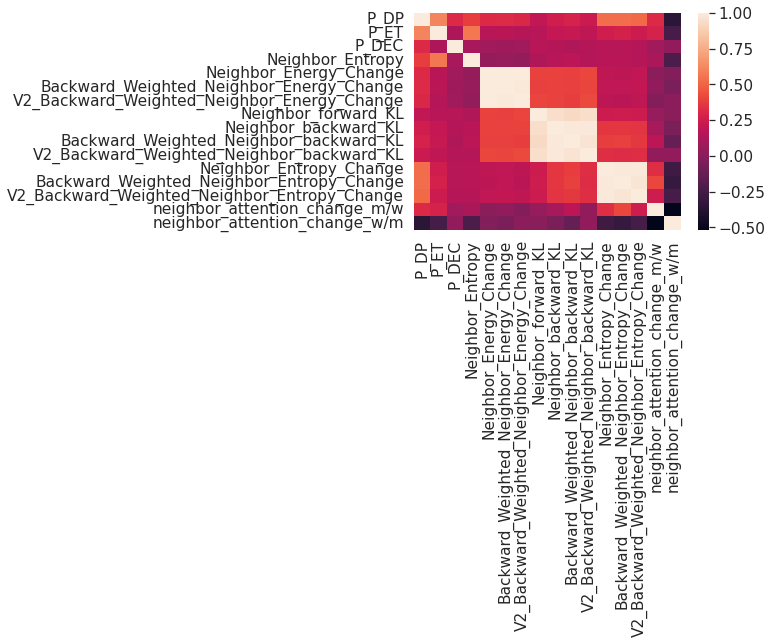

In [ ]:
import pandas as pd
import seaborn as sns

df_Ssym = pd.DataFrame(
    {'P_DP': mut_wild_predictions,
     'P_ET': entropy_predictions,
     'P_DEC': pssm_predictions,
     'Neighbor_Entropy' : neighbor_entropy_predictions,
     'Neighbor_Energy_Change' : neighbor_energy_change_predictions,
     'Backward_Weighted_Neighbor_Energy_Change' : backward_weighted_neighbor_energy_changes,
     'V2_Backward_Weighted_Neighbor_Energy_Change' : V2_backward_weighted_neighbor_energy_changes,
     'Neighbor_forward_KL' : neighbor_forward_KL_predictions,
     'Neighbor_backward_KL' : neighbor_backward_KL_predictions,
     'Backward_Weighted_Neighbor_backward_KL' : backward_weighted_neighbor_backward_KL,
     'V2_Backward_Weighted_Neighbor_backward_KL' : V2_backward_weighted_neighbor_backward_KL,
     'Neighbor_Entropy_Change' : neighbor_entropy_change_predictions,
     'Backward_Weighted_Neighbor_Entropy_Change' : backward_weighted_neighbor_entropy_changes,
     'V2_Backward_Weighted_Neighbor_Entropy_Change' : V2_backward_weighted_neighbor_entropy_changes,
     'neighbor_attention_change_m/w' : center_neighbor_weight_check_m_w,
     'neighbor_attention_change_w/m' : center_neighbor_weight_check_w_m
    })
corr = df_Ssym.corr()

sns.set(font_scale=1.4)
sns.heatmap(corr, 
        xticklabels=corr.columns,
        yticklabels=corr.columns)